In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def concat_results_pkl(old_results_path, new_results_path):
    results_old = pickle.load(open(old_results_path, 'rb'))
    results_new = pickle.load(open(new_results_path, 'rb'))
    results = results_old | results_new
    pickle.dump(results, open(old_results_path, 'wb'))

In [3]:
# concat_results_pkl('results/results.pkl', 'results.pkl')

In [4]:
def log_results(k: int = 1, metric: str = "recall", head: int | None = None):
    results = pickle.load(open(f"results/results.pkl", 'rb'))
    for dataset, v in results.items():
        print(dataset, k, metric)
        sorted_results = sorted(v.items(), key=lambda x: x[1][k][metric], reverse=True)
        if head: sorted_results = sorted_results[:head]
        for hyperparam_str, k_v in sorted_results:
            print(f"{hyperparam_str}: {k_v[k][metric]}")
        print()

def log_results_per_chunker(k: int = 1, metric: str = "recall"):
    results = pickle.load(open(f"results/results.pkl", 'rb'))
    for dataset, v in results.items():
        print(dataset, k, metric)
        sorted_results = sorted(v.items(), key=lambda x: x[1][k][metric], reverse=True)
        cache = set()
        for hyperparam_str, k_v in sorted_results:
            chunker = hyperparam_str.split("|")[0]
            if chunker not in cache:
                cache.add(chunker)
                print(f"{hyperparam_str}: {k_v[k][metric]}")
        print()

In [7]:
def results_pkl_to_df():
    results = pickle.load(open(f"results/results_evidence.pkl", 'rb'))
    results_list = []
    for dataset, chunkers in results.items():
        for chunker_name, metrics_dict in chunkers.items():
            for number, metrics in metrics_dict.items():
                entry = {
                    'dataset': dataset,
                    'chunker_str': chunker_name,
                    'k': number,
                    **metrics
                }
                results_list.append(entry)

    # Create the DataFrame
    df = pd.DataFrame(results_list)
    df[['chunker', 'hyperparameters']] = df['chunker_str'].apply(process_chunker_str)
    df.drop(columns=['chunker_str'], inplace=True)
    return df

def process_chunker_str(chunker_str):
    parts = chunker_str.split('|')
    chunker_name = parts[0]
    hyperparameters = {}
    for part in parts[1:]:
        if '_' in part:
            param_name, param_value = part.rsplit('_', 1)
            if param_name == 'dataset':
                continue
            param_value = param_value.replace('-', '.')
            try:
                if '.' in param_value:
                    param_value = float(param_value)
                else:
                    param_value = int(param_value)
            except ValueError:
                pass
            hyperparameters[param_name] = param_value
    return pd.Series([chunker_name, hyperparameters], index=['chunker', 'hyperparameters'])

def get_top_results(df, dataset, metric, k, head=10):
    return df[(df['dataset'] == dataset) & (df['k'] == k)].sort_values(metric, ascending=False).head(head)

def get_top_results_per_chunker(df, dataset, metric, k):
    return df[(df['dataset'] == dataset) & (df['k'] == k)].groupby('chunker').apply(lambda x: x.sort_values(metric, ascending=False).head(1)).reset_index(drop=True).sort_values(metric, ascending=False)

In [8]:
df = results_pkl_to_df()

# ConditionalQA

## F1

In [20]:
for k in [1,3,5]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'techqa', 'f1', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
2  techqa  1  0.582021   0.308323  0.403104             DBSCANChunker   
3  techqa  1  0.534639   0.315167  0.396563          LangchainChunker   
1  techqa  1  0.586368   0.296464  0.393817               BaseChunker   
0  techqa  1  0.463669   0.303852  0.367122  AbsoluteLangchainChunker   
4  techqa  1  0.342251   0.344057  0.343151         PositionalChunker   
5  techqa  1  0.321377   0.350918  0.335498      SingleLinkageChunker   

                                     hyperparameters  
2  {'lamda': 0, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
1                                                 {}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                   {'lamda': 0.75, 'n_clusters': 2}

k=3


dataset  k    recall  precision        f1                   chunker  \
4  techqa  3  0.398865   0.230735  0.292351         PositionalChunker   
5  techqa  3  0.398865   0.230735  0.292351      SingleLinkageChunker   
3  techqa  3  0.322269   0.255254  0.284873          LangchainChunker   
0  techqa  3  0.437410   0.205156  0.279309  AbsoluteLangchainChunker   
2  techqa  3  0.432295   0.181012  0.255176             DBSCANChunker   
1  techqa  3  0.742020   0.099328  0.175202               BaseChunker   

                                     hyperparameters  
4              {'n_chunks': 4, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 4}  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0.25, 'eps': 0.2, 'min_samples_per_c...  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
3  techqa  5  0.325322   0.227509  0.267762          LangchainChunker   
4  techqa  5  0.356041   0.203020  0.258589         PositionalChunker   
0  techqa  5  0.428793   0.182163  0.255699  AbsoluteLangchainChunker   
5  techqa  5  0.347571   0.189034  0.244883      SingleLinkageChunker   
2  techqa  5  0.247365   0.186232  0.212489             DBSCANChunker   
1  techqa  5  0.811330   0.060241  0.112155               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 7, 'n_sents_overlap': 1}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                      {'lamda': 1, 'n_clusters': 7}  
2  {'lamda': 0.5, 'eps': 0.1, 'min_samples_per_cl...  
1                                                 {}

## Recall

In [9]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'conditionalqa', 'recall', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
1  conditionalqa  1  0.782288   0.047832  0.090152               BaseChunker   
2  conditionalqa  1  0.782288   0.047832  0.090152             DBSCANChunker   
3  conditionalqa  1  0.782288   0.047832  0.090152          LangchainChunker   
4  conditionalqa  1  0.597767   0.079153  0.139794         PositionalChunker   
5  conditionalqa  1  0.583861   0.074208  0.131679      SingleLinkageChunker   
0  conditionalqa  1  0.566139   0.098424  0.167695  AbsoluteLangchainChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 2}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

k=3


dataset  k    recall  precision        f1                   chunker  \
1  conditionalqa  3  0.911439   0.015668  0.030807               BaseChunker   
2  conditionalqa  3  0.911439   0.015668  0.030807             DBSCANChunker   
3  conditionalqa  3  0.911439   0.015668  0.030807          LangchainChunker   
4  conditionalqa  3  0.848638   0.034983  0.067196         PositionalChunker   
5  conditionalqa  3  0.848638   0.034983  0.067196      SingleLinkageChunker   
0  conditionalqa  3  0.826470   0.048685  0.091954  AbsoluteLangchainChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
4              {'n_chunks': 2, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 2}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

k=5


dataset  k    recall  precision        f1                   chunker  \
1  conditionalqa  5  0.952030   0.009355  0.018528               BaseChunker   
2  conditionalqa  5  0.952030   0.009355  0.018528             DBSCANChunker   
3  conditionalqa  5  0.952030   0.009416  0.018647          LangchainChunker   
4  conditionalqa  5  0.909862   0.031801  0.061455         PositionalChunker   
5  conditionalqa  5  0.909862   0.031801  0.061455      SingleLinkageChunker   
0  conditionalqa  5  0.885390   0.032631  0.062943  AbsoluteLangchainChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
4              {'n_chunks': 3, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 3}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

k=10


dataset   k    recall  precision        f1                   chunker  \
1  conditionalqa  10  0.974170   0.004651  0.009257               BaseChunker   
2  conditionalqa  10  0.974170   0.004651  0.009257             DBSCANChunker   
3  conditionalqa  10  0.974170   0.004651  0.009258          LangchainChunker   
4  conditionalqa  10  0.957103   0.010838  0.021434         PositionalChunker   
5  conditionalqa  10  0.952798   0.010315  0.020410      SingleLinkageChunker   
0  conditionalqa  10  0.945616   0.017782  0.034908  AbsoluteLangchainChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 2}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

## Precision

In [10]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'conditionalqa', 'precision', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
0  conditionalqa  1  0.144581   0.381919  0.209756  AbsoluteLangchainChunker   
2  conditionalqa  1  0.145602   0.370849  0.209105             DBSCANChunker   
3  conditionalqa  1  0.154160   0.365929  0.216930          LangchainChunker   
4  conditionalqa  1  0.389442   0.164572  0.231371         PositionalChunker   
5  conditionalqa  1  0.360723   0.159774  0.221458      SingleLinkageChunker   
1  conditionalqa  1  0.782288   0.047832  0.090152               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                     {'lamda': 1, 'n_clusters': 10}  
1                                                 {}

k=3


dataset  k    recall  precision        f1                   chunker  \
0  conditionalqa  3  0.201118   0.199569  0.200341  AbsoluteLangchainChunker   
3  conditionalqa  3  0.226133   0.199200  0.211814          LangchainChunker   
2  conditionalqa  3  0.204818   0.191788  0.198089             DBSCANChunker   
4  conditionalqa  3  0.632494   0.100306  0.173152         PositionalChunker   
5  conditionalqa  3  0.632494   0.100306  0.173152      SingleLinkageChunker   
1  conditionalqa  3  0.911439   0.015668  0.030807               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
5                     {'lamda': 1, 'n_clusters': 10}  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
0  conditionalqa  5  0.235120   0.150431  0.183474  AbsoluteLangchainChunker   
3  conditionalqa  5  0.265285   0.147971  0.189977          LangchainChunker   
2  conditionalqa  5  0.244809   0.145253  0.182326             DBSCANChunker   
4  conditionalqa  5  0.717504   0.073920  0.134031         PositionalChunker   
5  conditionalqa  5  0.717504   0.073920  0.134031      SingleLinkageChunker   
1  conditionalqa  5  0.952030   0.009355  0.018528               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
5                     {'lamda': 1, 'n_clusters': 10}  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
0  conditionalqa  10  0.311413   0.104657  0.156664  AbsoluteLangchainChunker   
3  conditionalqa  10  0.354172   0.102931  0.159506          LangchainChunker   
2  conditionalqa  10  0.318823   0.100235  0.152519             DBSCANChunker   
4  conditionalqa  10  0.832830   0.044056  0.083686         PositionalChunker   
5  conditionalqa  10  0.819752   0.043676  0.082933      SingleLinkageChunker   
1  conditionalqa  10  0.974170   0.004651  0.009257               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                     {'lamda': 1, 'n_clusters': 10}  
1                                                 {}

# Qasper

## F1

In [11]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'qasper', 'f1', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
0  qasper  1  0.163738   0.060794  0.088667  AbsoluteLangchainChunker   
5  qasper  1  0.197278   0.055499  0.086628      SingleLinkageChunker   
4  qasper  1  0.204127   0.054979  0.086626         PositionalChunker   
3  qasper  1  0.137980   0.062281  0.085823          LangchainChunker   
1  qasper  1  0.972549   0.042921  0.082214               BaseChunker   
2  qasper  1  0.972549   0.042921  0.082214             DBSCANChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
5                   {'lamda': 0.75, 'n_clusters': 5}  
4              {'n_chunks': 6, 'n_sents_overlap': 1}  
3  {'breakpoint_threshold_type_standard': 'deviat...  
1                                                 {}  
2  {'lamda': 0.5, 'eps': 0.5, 'min_samples_per_cl...

k=3


dataset  k    recall  precision        f1                   chunker  \
4  qasper  3  0.391658   0.055191  0.096748         PositionalChunker   
5  qasper  3  0.411183   0.051306  0.091229      SingleLinkageChunker   
0  qasper  3  0.417021   0.049359  0.088270  AbsoluteLangchainChunker   
3  qasper  3  0.190694   0.056716  0.087429          LangchainChunker   
2  qasper  3  0.856652   0.036650  0.070292             DBSCANChunker   
1  qasper  3  0.996078   0.014210  0.028021               BaseChunker   

                                     hyperparameters  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                   {'lamda': 0.75, 'n_clusters': 9}  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
3  qasper  5  0.286501   0.052973  0.089414          LangchainChunker   
4  qasper  5  0.547771   0.047866  0.088040         PositionalChunker   
5  qasper  5  0.547771   0.047866  0.088040      SingleLinkageChunker   
0  qasper  5  0.426959   0.048362  0.086883  AbsoluteLangchainChunker   
2  qasper  5  0.780330   0.029506  0.056862             DBSCANChunker   
1  qasper  5  1.000000   0.008587  0.017027               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
5                     {'lamda': 1, 'n_clusters': 10}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0.5, 'eps': 0.1, 'min_samples_per_cl...  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
3  qasper  10  0.435371   0.047115  0.085028          LangchainChunker   
0  qasper  10  0.617950   0.039993  0.075123  AbsoluteLangchainChunker   
5  qasper  10  0.808448   0.036797  0.070391      SingleLinkageChunker   
4  qasper  10  0.808448   0.036797  0.070391         PositionalChunker   
2  qasper  10  0.083770   0.029879  0.044047             DBSCANChunker   
1  qasper  10  1.000000   0.004211  0.008386               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                     {'lamda': 1, 'n_clusters': 10}  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
1                                                 {}

## Recall

In [12]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'qasper', 'recall', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
1  qasper  1  0.972549   0.042921  0.082214               BaseChunker   
2  qasper  1  0.972549   0.042921  0.082214             DBSCANChunker   
3  qasper  1  0.909509   0.042687  0.081547          LangchainChunker   
0  qasper  1  0.540354   0.037353  0.069876  AbsoluteLangchainChunker   
5  qasper  1  0.417237   0.038534  0.070552      SingleLinkageChunker   
4  qasper  1  0.412971   0.033333  0.061687         PositionalChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                   {'lamda': 0.25, 'n_clusters': 2}  
4              {'n_chunks': 2, 'n_sents_overlap': 0}

k=3


dataset  k    recall  precision        f1                   chunker  \
1  qasper  3  0.996078   0.014210  0.028021               BaseChunker   
2  qasper  3  0.996078   0.014210  0.028021             DBSCANChunker   
3  qasper  3  0.981176   0.017283  0.033968          LangchainChunker   
0  qasper  3  0.884022   0.030742  0.059417  AbsoluteLangchainChunker   
5  qasper  3  0.864479   0.025182  0.048939      SingleLinkageChunker   
4  qasper  3  0.816554   0.026022  0.050436         PositionalChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                      {'lamda': 0, 'n_clusters': 2}  
4              {'n_chunks': 2, 'n_sents_overlap': 0}

k=5


dataset  k    recall  precision        f1                   chunker  \
1  qasper  5  1.000000   0.008587  0.017027               BaseChunker   
2  qasper  5  1.000000   0.008587  0.017027             DBSCANChunker   
3  qasper  5  0.992157   0.010703  0.021177          LangchainChunker   
0  qasper  5  0.931268   0.019981  0.039123  AbsoluteLangchainChunker   
5  qasper  5  0.928777   0.015893  0.031251      SingleLinkageChunker   
4  qasper  5  0.869589   0.015980  0.031383         PositionalChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                      {'lamda': 0, 'n_clusters': 2}  
4              {'n_chunks': 2, 'n_sents_overlap': 0}

k=10


dataset   k    recall  precision        f1                   chunker  \
1  qasper  10  1.000000   0.004211  0.008386               BaseChunker   
2  qasper  10  1.000000   0.004211  0.008386             DBSCANChunker   
3  qasper  10  1.000000   0.005189  0.010324          LangchainChunker   
5  qasper  10  0.968307   0.008324  0.016507      SingleLinkageChunker   
0  qasper  10  0.955154   0.009928  0.019652  AbsoluteLangchainChunker   
4  qasper  10  0.919294   0.017001  0.033385         PositionalChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
5                      {'lamda': 0, 'n_clusters': 2}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 4, 'n_sents_overlap': 0}

## Precision

In [13]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'qasper', 'precision', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
3  qasper  1  0.137980   0.062281  0.085823          LangchainChunker   
0  qasper  1  0.163738   0.060794  0.088667  AbsoluteLangchainChunker   
5  qasper  1  0.147662   0.058350  0.083646      SingleLinkageChunker   
4  qasper  1  0.147662   0.058350  0.083646         PositionalChunker   
1  qasper  1  0.972549   0.042921  0.082214               BaseChunker   
2  qasper  1  0.972549   0.042921  0.082214             DBSCANChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
5                      {'lamda': 1, 'n_clusters': 9}  
4              {'n_chunks': 9, 'n_sents_overlap': 0}  
1                                                 {}  
2  {'lamda': 0.5, 'eps': 0.5, 'min_samples_per_cl...

k=3


dataset  k    recall  precision        f1                   chunker  \
3  qasper  3  0.092096   0.059617  0.072380          LangchainChunker   
4  qasper  3  0.391658   0.055191  0.096748         PositionalChunker   
5  qasper  3  0.411183   0.051306  0.091229      SingleLinkageChunker   
0  qasper  3  0.417021   0.049359  0.088270  AbsoluteLangchainChunker   
2  qasper  3  0.712703   0.036852  0.070080             DBSCANChunker   
1  qasper  3  0.996078   0.014210  0.028021               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                   {'lamda': 0.75, 'n_clusters': 9}  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0, 'eps': 0.2, 'min_samples_per_clus...  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
3  qasper  5  0.127076   0.053561  0.075359          LangchainChunker   
0  qasper  5  0.426959   0.048362  0.086883  AbsoluteLangchainChunker   
5  qasper  5  0.547771   0.047866  0.088040      SingleLinkageChunker   
4  qasper  5  0.547771   0.047866  0.088040         PositionalChunker   
2  qasper  5  0.068363   0.030200  0.041893             DBSCANChunker   
1  qasper  5  1.000000   0.008587  0.017027               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                     {'lamda': 1, 'n_clusters': 10}  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
3  qasper  10  0.201507   0.048801  0.078574          LangchainChunker   
0  qasper  10  0.271444   0.040063  0.069820  AbsoluteLangchainChunker   
5  qasper  10  0.808448   0.036797  0.070391      SingleLinkageChunker   
4  qasper  10  0.808448   0.036797  0.070391         PositionalChunker   
2  qasper  10  0.083770   0.029879  0.044047             DBSCANChunker   
1  qasper  10  1.000000   0.004211  0.008386               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                     {'lamda': 1, 'n_clusters': 10}  
4             {'n_chunks': 10, 'n_sents_overlap': 0}  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
1                                                 {}

# CUAD

## F1

In [14]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'cuad', 'f1', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
3    cuad  1  0.008300   0.014458  0.010546          LangchainChunker   
0    cuad  1  0.006827   0.012048  0.008716  AbsoluteLangchainChunker   
2    cuad  1  0.006827   0.012048  0.008716             DBSCANChunker   
5    cuad  1  0.007989   0.005927  0.006805      SingleLinkageChunker   
4    cuad  1  0.010821   0.004724  0.006577         PositionalChunker   
1    cuad  1  0.012048   0.000576  0.001100               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
5                   {'lamda': 0.25, 'n_clusters': 7}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=3


dataset  k    recall  precision        f1                   chunker  \
0    cuad  3  0.018581   0.008353  0.011525  AbsoluteLangchainChunker   
2    cuad  3  0.013601   0.008032  0.010100             DBSCANChunker   
3    cuad  3  0.015207   0.007229  0.009800          LangchainChunker   
5    cuad  3  0.018994   0.002595  0.004566      SingleLinkageChunker   
4    cuad  3  0.021109   0.001951  0.003572         PositionalChunker   
1    cuad  3  0.031325   0.000300  0.000595               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
5                     {'lamda': 0, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
0    cuad  5  0.027109   0.009248  0.013792  AbsoluteLangchainChunker   
3    cuad  5  0.024057   0.007679  0.011642          LangchainChunker   
2    cuad  5  0.022268   0.007871  0.011631             DBSCANChunker   
5    cuad  5  0.025697   0.002182  0.004023      SingleLinkageChunker   
4    cuad  5  0.033572   0.001759  0.003343         PositionalChunker   
1    cuad  5  0.057831   0.000347  0.000689               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
5                     {'lamda': 0, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
0    cuad  10  0.033186   0.006794  0.011278  AbsoluteLangchainChunker   
2    cuad  10  0.029346   0.005822  0.009716             DBSCANChunker   
3    cuad  10  0.030952   0.005540  0.009397          LangchainChunker   
5    cuad  10  0.042841   0.002301  0.004367      SingleLinkageChunker   
4    cuad  10  0.058277   0.001715  0.003332         PositionalChunker   
1    cuad  10  0.115663   0.000315  0.000628               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                     {'lamda': 0, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

## Recall

In [15]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'cuad', 'recall', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
5    cuad  1  0.014703   0.003345  0.005450      SingleLinkageChunker   
2    cuad  1  0.014458   0.002249  0.003893             DBSCANChunker   
4    cuad  1  0.014266   0.003893  0.006116         PositionalChunker   
1    cuad  1  0.012048   0.000576  0.001100               BaseChunker   
3    cuad  1  0.012048   0.000576  0.001100          LangchainChunker   
0    cuad  1  0.006827   0.012048  0.008716  AbsoluteLangchainChunker   

                                     hyperparameters  
5                   {'lamda': 0.25, 'n_clusters': 5}  
2  {'lamda': 0.5, 'eps': 0.2, 'min_samples_per_cl...  
4              {'n_chunks': 7, 'n_sents_overlap': 1}  
1                                                 {}  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'distance', 'bre...

k=3


dataset  k    recall  precision        f1                   chunker  \
2    cuad  3  0.032129   0.000310  0.000613             DBSCANChunker   
1    cuad  3  0.031325   0.000300  0.000595               BaseChunker   
3    cuad  3  0.031325   0.000300  0.000595          LangchainChunker   
4    cuad  3  0.027216   0.001398  0.002659         PositionalChunker   
5    cuad  3  0.027216   0.001398  0.002659      SingleLinkageChunker   
0    cuad  3  0.018581   0.008353  0.011525  AbsoluteLangchainChunker   

                                     hyperparameters  
2  {'lamda': 0, 'eps': 0.5, 'min_samples_per_clus...  
1                                                 {}  
3  {'breakpoint_threshold_type_standard': 'deviat...  
4              {'n_chunks': 6, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 6}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

k=5


dataset  k    recall  precision        f1                   chunker  \
1    cuad  5  0.057831   0.000347  0.000689               BaseChunker   
2    cuad  5  0.057831   0.000347  0.000689             DBSCANChunker   
3    cuad  5  0.057831   0.000347  0.000689          LangchainChunker   
5    cuad  5  0.046115   0.000698  0.001376      SingleLinkageChunker   
4    cuad  5  0.041597   0.001541  0.002972         PositionalChunker   
0    cuad  5  0.027109   0.009248  0.013792  AbsoluteLangchainChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
5                   {'lamda': 0.75, 'n_clusters': 2}  
4              {'n_chunks': 8, 'n_sents_overlap': 0}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

k=10


dataset   k    recall  precision        f1                   chunker  \
2    cuad  10  0.121285   0.000353  0.000704             DBSCANChunker   
1    cuad  10  0.115663   0.000315  0.000628               BaseChunker   
3    cuad  10  0.115663   0.000315  0.000628          LangchainChunker   
5    cuad  10  0.078398   0.000885  0.001749      SingleLinkageChunker   
4    cuad  10  0.063757   0.001060  0.002085         PositionalChunker   
0    cuad  10  0.040080   0.001360  0.002631  AbsoluteLangchainChunker   

                                     hyperparameters  
2  {'lamda': 0, 'eps': 0.5, 'min_samples_per_clus...  
1                                                 {}  
3  {'breakpoint_threshold_type_standard': 'deviat...  
5                   {'lamda': 0.75, 'n_clusters': 4}  
4              {'n_chunks': 8, 'n_sents_overlap': 0}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...

## Precision

In [16]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'cuad', 'precision', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
3    cuad  1  0.008300   0.014458  0.010546          LangchainChunker   
0    cuad  1  0.006827   0.012048  0.008716  AbsoluteLangchainChunker   
2    cuad  1  0.006827   0.012048  0.008716             DBSCANChunker   
5    cuad  1  0.007989   0.005927  0.006805      SingleLinkageChunker   
4    cuad  1  0.010821   0.004724  0.006577         PositionalChunker   
1    cuad  1  0.012048   0.000576  0.001100               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
5                   {'lamda': 0.25, 'n_clusters': 7}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=3


dataset  k    recall  precision        f1                   chunker  \
0    cuad  3  0.018581   0.008353  0.011525  AbsoluteLangchainChunker   
2    cuad  3  0.013601   0.008032  0.010100             DBSCANChunker   
3    cuad  3  0.015207   0.007229  0.009800          LangchainChunker   
5    cuad  3  0.014701   0.002611  0.004435      SingleLinkageChunker   
4    cuad  3  0.021109   0.001951  0.003572         PositionalChunker   
1    cuad  3  0.031325   0.000300  0.000595               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
5                  {'lamda': 0.25, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
0    cuad  5  0.027109   0.009248  0.013792  AbsoluteLangchainChunker   
2    cuad  5  0.022268   0.007871  0.011631             DBSCANChunker   
3    cuad  5  0.024057   0.007679  0.011642          LangchainChunker   
5    cuad  5  0.025697   0.002182  0.004023      SingleLinkageChunker   
4    cuad  5  0.033572   0.001759  0.003343         PositionalChunker   
1    cuad  5  0.057831   0.000347  0.000689               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
5                     {'lamda': 0, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
0    cuad  10  0.033186   0.006794  0.011278  AbsoluteLangchainChunker   
2    cuad  10  0.029346   0.005822  0.009716             DBSCANChunker   
3    cuad  10  0.030952   0.005540  0.009397          LangchainChunker   
5    cuad  10  0.042841   0.002301  0.004367      SingleLinkageChunker   
4    cuad  10  0.058277   0.001715  0.003332         PositionalChunker   
1    cuad  10  0.115663   0.000315  0.000628               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                     {'lamda': 0, 'n_clusters': 10}  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
1                                                 {}

# TechQA

## F1

In [17]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'techqa', 'f1', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
2  techqa  1  0.582021   0.308323  0.403104             DBSCANChunker   
3  techqa  1  0.534639   0.315167  0.396563          LangchainChunker   
1  techqa  1  0.586368   0.296464  0.393817               BaseChunker   
0  techqa  1  0.463669   0.303852  0.367122  AbsoluteLangchainChunker   
4  techqa  1  0.342251   0.344057  0.343151         PositionalChunker   
5  techqa  1  0.321377   0.350918  0.335498      SingleLinkageChunker   

                                     hyperparameters  
2  {'lamda': 0, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
1                                                 {}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                   {'lamda': 0.75, 'n_clusters': 2}

k=3


dataset  k    recall  precision        f1                   chunker  \
4  techqa  3  0.398865   0.230735  0.292351         PositionalChunker   
5  techqa  3  0.398865   0.230735  0.292351      SingleLinkageChunker   
3  techqa  3  0.322269   0.255254  0.284873          LangchainChunker   
0  techqa  3  0.437410   0.205156  0.279309  AbsoluteLangchainChunker   
2  techqa  3  0.432295   0.181012  0.255176             DBSCANChunker   
1  techqa  3  0.742020   0.099328  0.175202               BaseChunker   

                                     hyperparameters  
4              {'n_chunks': 4, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 4}  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0.25, 'eps': 0.2, 'min_samples_per_c...  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
3  techqa  5  0.325322   0.227509  0.267762          LangchainChunker   
4  techqa  5  0.356041   0.203020  0.258589         PositionalChunker   
0  techqa  5  0.428793   0.182163  0.255699  AbsoluteLangchainChunker   
5  techqa  5  0.347571   0.189034  0.244883      SingleLinkageChunker   
2  techqa  5  0.247365   0.186232  0.212489             DBSCANChunker   
1  techqa  5  0.811330   0.060241  0.112155               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 7, 'n_sents_overlap': 1}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                      {'lamda': 1, 'n_clusters': 7}  
2  {'lamda': 0.5, 'eps': 0.1, 'min_samples_per_cl...  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
0  techqa  10  0.351709   0.158239  0.218274  AbsoluteLangchainChunker   
3  techqa  10  0.269753   0.178249  0.214656          LangchainChunker   
2  techqa  10  0.250722   0.166322  0.199982             DBSCANChunker   
4  techqa  10  0.405142   0.130667  0.197602         PositionalChunker   
5  techqa  10  0.420791   0.126988  0.195099      SingleLinkageChunker   
1  techqa  10  0.873316   0.031349  0.060525               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 8}  
1                                                 {}

## Recall

In [18]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'techqa', 'recall', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
1  techqa  1  0.586368   0.296464  0.393817               BaseChunker   
2  techqa  1  0.586368   0.296464  0.393817             DBSCANChunker   
3  techqa  1  0.574917   0.288411  0.384124          LangchainChunker   
0  techqa  1  0.463669   0.303852  0.367122  AbsoluteLangchainChunker   
4  techqa  1  0.342251   0.344057  0.343151         PositionalChunker   
5  techqa  1  0.341244   0.328778  0.334895      SingleLinkageChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 2}

k=3


dataset  k    recall  precision        f1                   chunker  \
1  techqa  3  0.742020   0.099328  0.175202               BaseChunker   
2  techqa  3  0.742020   0.099342  0.175225             DBSCANChunker   
3  techqa  3  0.742020   0.099465  0.175417          LangchainChunker   
0  techqa  3  0.619290   0.151872  0.243925  AbsoluteLangchainChunker   
4  techqa  3  0.578809   0.187398  0.283129         PositionalChunker   
5  techqa  3  0.573794   0.160582  0.250937      SingleLinkageChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 2}

k=5


dataset  k    recall  precision        f1                   chunker  \
1  techqa  5  0.811330   0.060241  0.112155               BaseChunker   
2  techqa  5  0.811330   0.060245  0.112161             DBSCANChunker   
3  techqa  5  0.811330   0.060447  0.112512          LangchainChunker   
0  techqa  5  0.728369   0.104641  0.182993  AbsoluteLangchainChunker   
4  techqa  5  0.687678   0.100207  0.174924         PositionalChunker   
5  techqa  5  0.687678   0.100207  0.174924      SingleLinkageChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 0}  
5                      {'lamda': 1, 'n_clusters': 2}

k=10


dataset   k    recall  precision        f1                   chunker  \
1  techqa  10  0.873316   0.031349  0.060525               BaseChunker   
2  techqa  10  0.873316   0.031349  0.060525             DBSCANChunker   
3  techqa  10  0.873316   0.031437  0.060689          LangchainChunker   
0  techqa  10  0.823307   0.058624  0.109455  AbsoluteLangchainChunker   
4  techqa  10  0.756531   0.060897  0.112721         PositionalChunker   
5  techqa  10  0.755633   0.055996  0.104265      SingleLinkageChunker   

                                     hyperparameters  
1                                                 {}  
2  {'lamda': 1, 'eps': 0.5, 'min_samples_per_clus...  
3  {'breakpoint_threshold_type_standard': 'deviat...  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
4              {'n_chunks': 2, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 2}

## Precision

In [19]:
for k in [1,3,5,10]:
    print(f"k={k}")
    display(get_top_results_per_chunker(df, 'techqa', 'precision', k))

k=1


dataset  k    recall  precision        f1                   chunker  \
4  techqa  1  0.149510   0.447149  0.224092         PositionalChunker   
0  techqa  1  0.119778   0.441476  0.188433  AbsoluteLangchainChunker   
5  techqa  1  0.134839   0.429376  0.205229      SingleLinkageChunker   
3  techqa  1  0.130037   0.405852  0.196966          LangchainChunker   
2  techqa  1  0.081096   0.380680  0.133708             DBSCANChunker   
1  techqa  1  0.586368   0.296464  0.393817               BaseChunker   

                                     hyperparameters  
4              {'n_chunks': 8, 'n_sents_overlap': 1}  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
5                      {'lamda': 1, 'n_clusters': 8}  
3  {'breakpoint_threshold_type': 'percentile', 'b...  
2  {'lamda': 0.25, 'eps': 0.1, 'min_samples_per_c...  
1                                                 {}

k=3


dataset  k    recall  precision        f1                   chunker  \
0  techqa  3  0.156815   0.302181  0.206479  AbsoluteLangchainChunker   
3  techqa  3  0.170223   0.301418  0.217573          LangchainChunker   
4  techqa  3  0.212064   0.282300  0.242193         PositionalChunker   
5  techqa  3  0.202446   0.274522  0.233038      SingleLinkageChunker   
2  techqa  3  0.154673   0.272092  0.197229             DBSCANChunker   
1  techqa  3  0.742020   0.099328  0.175202               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'gradient', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                     {'lamda': 0, 'n_clusters': 10}  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
1                                                 {}

k=5


dataset  k    recall  precision        f1                   chunker  \
3  techqa  5  0.214115   0.242556  0.227449          LangchainChunker   
0  techqa  5  0.189850   0.238836  0.211544  AbsoluteLangchainChunker   
2  techqa  5  0.192774   0.226367  0.208224             DBSCANChunker   
4  techqa  5  0.276043   0.211868  0.239735         PositionalChunker   
5  techqa  5  0.292502   0.202867  0.239575      SingleLinkageChunker   
1  techqa  5  0.811330   0.060241  0.112155               BaseChunker   

                                     hyperparameters  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4             {'n_chunks': 10, 'n_sents_overlap': 1}  
5                      {'lamda': 1, 'n_clusters': 9}  
1                                                 {}

k=10


dataset   k    recall  precision        f1                   chunker  \
0  techqa  10  0.241067   0.178569  0.205164  AbsoluteLangchainChunker   
3  techqa  10  0.269753   0.178249  0.214656          LangchainChunker   
2  techqa  10  0.250722   0.166322  0.199982             DBSCANChunker   
4  techqa  10  0.405142   0.130667  0.197602         PositionalChunker   
5  techqa  10  0.372959   0.129324  0.192054      SingleLinkageChunker   
1  techqa  10  0.873316   0.031349  0.060525               BaseChunker   

                                     hyperparameters  
0  {'breakpoint_threshold_type': 'distance', 'bre...  
3  {'breakpoint_threshold_type': 'gradient', 'bre...  
2  {'lamda': 0, 'eps': 0.1, 'min_samples_per_clus...  
4              {'n_chunks': 9, 'n_sents_overlap': 1}  
5                     {'lamda': 1, 'n_clusters': 10}  
1                                                 {}

# Hyperparameter Comparison

In [20]:
def get_chunker_df(df, chunker, **kwargs):
    subset_df = df[df['chunker'] == chunker].reset_index(drop=True)
    hyperparams_expanded = subset_df['hyperparameters'].apply(pd.Series)
    return pd.concat([subset_df.drop('hyperparameters', axis=1), hyperparams_expanded], axis=1)

## SingleLinkageChunker

### n_clusters

Showing plot for k=1


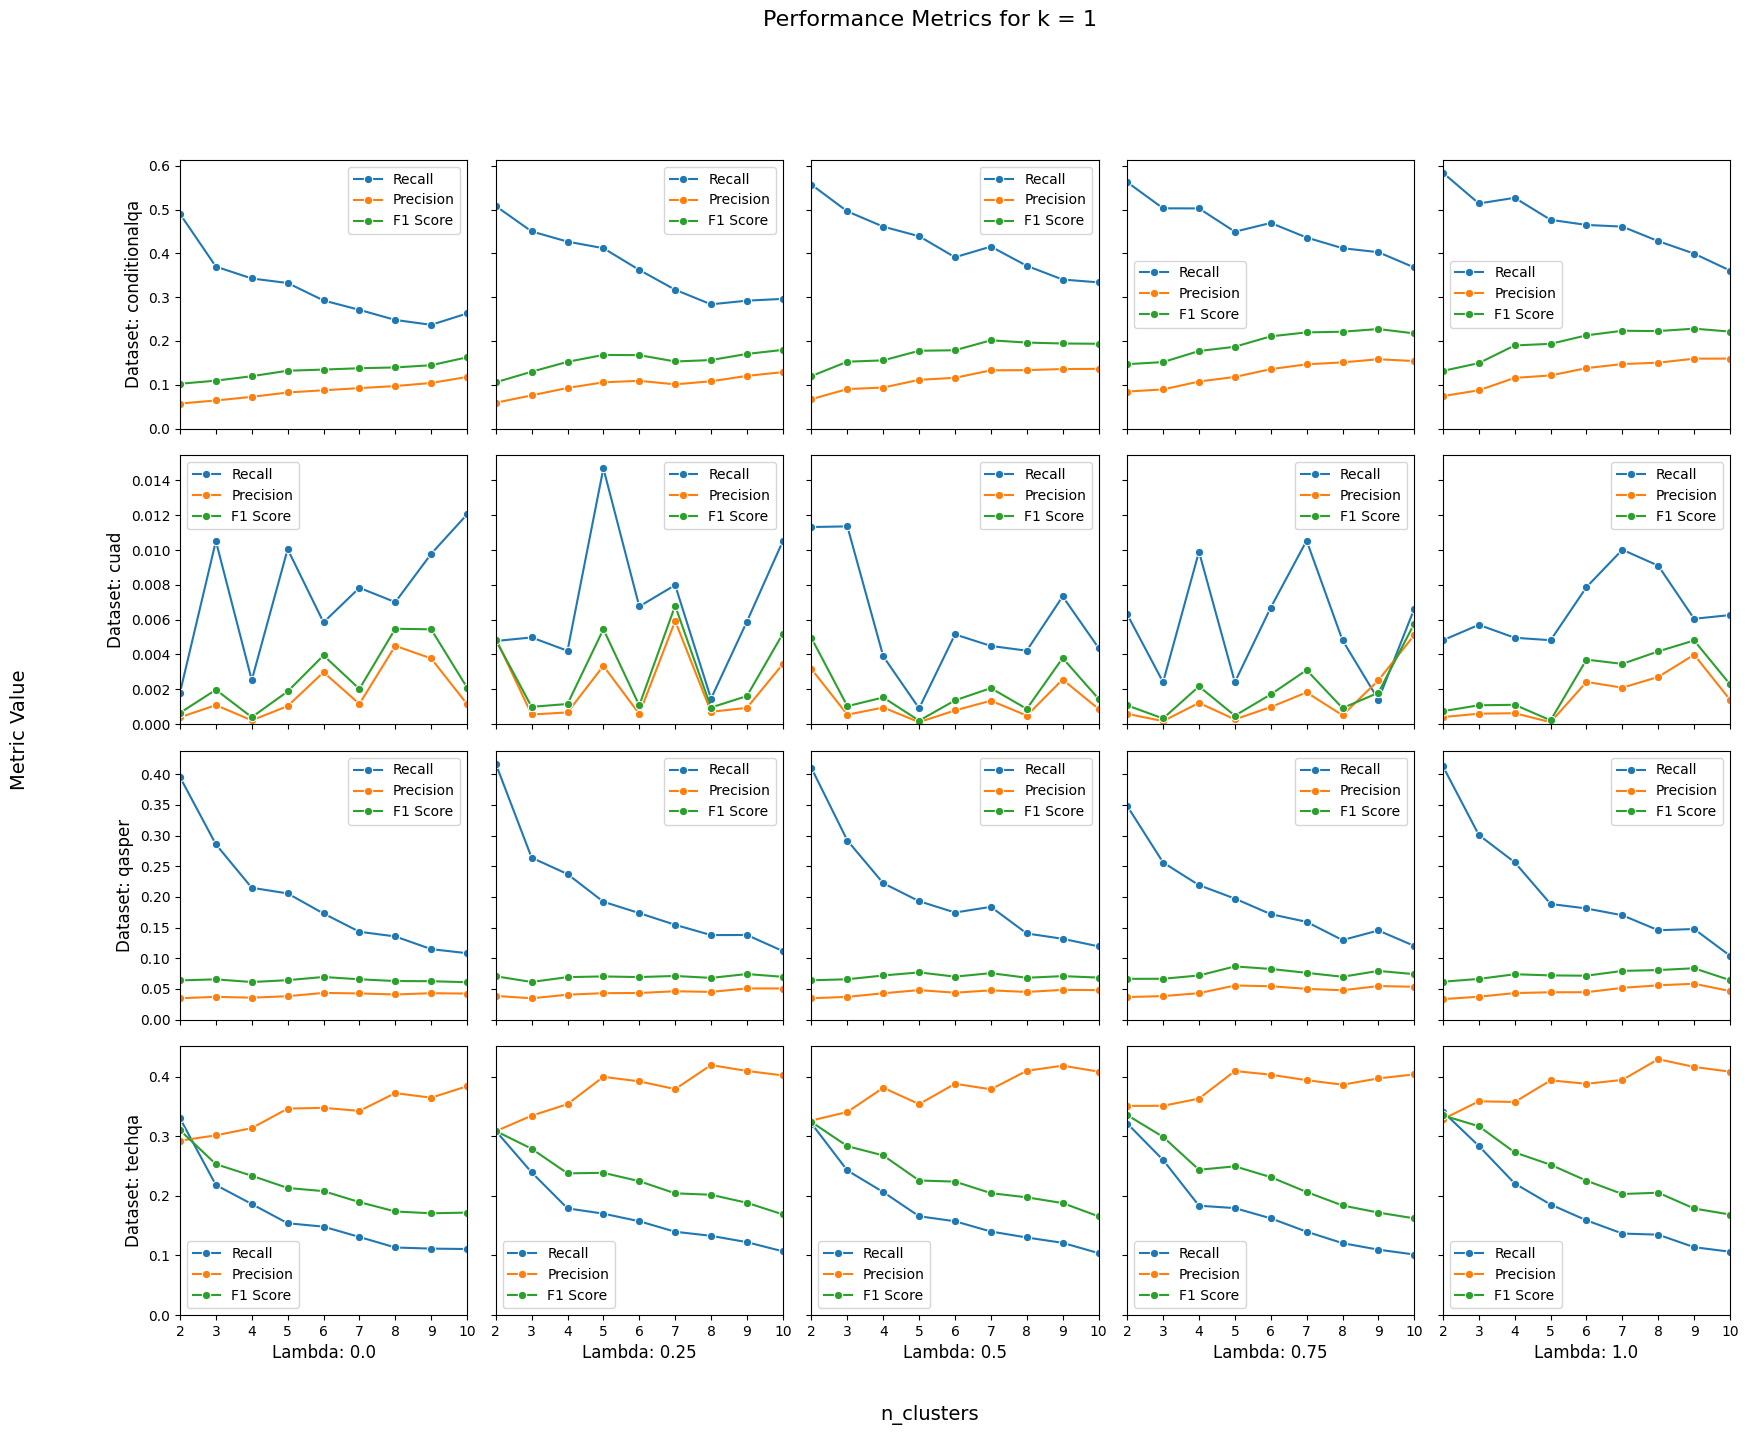

Showing plot for k=3


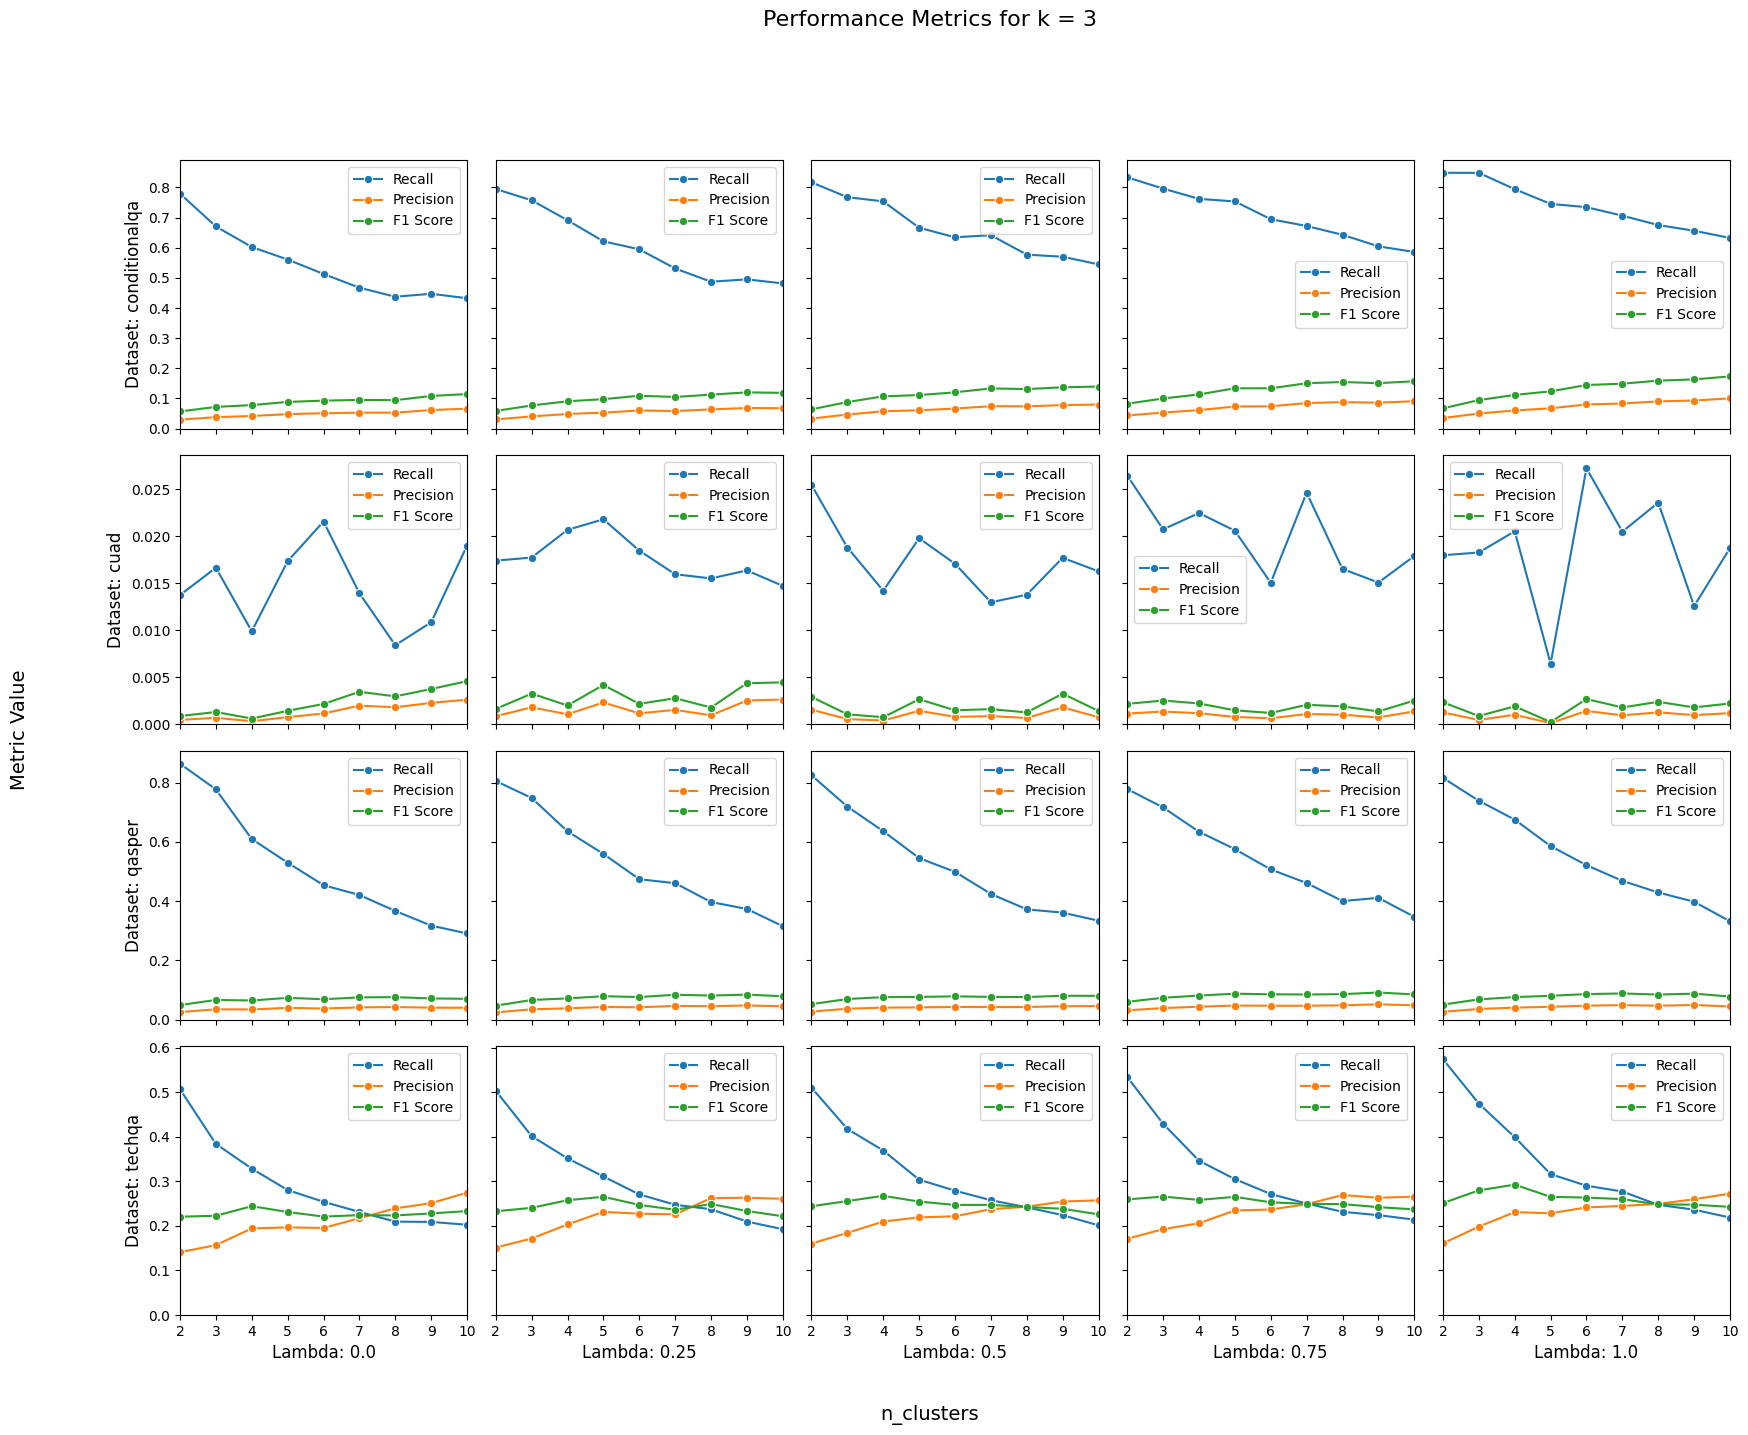

Showing plot for k=5


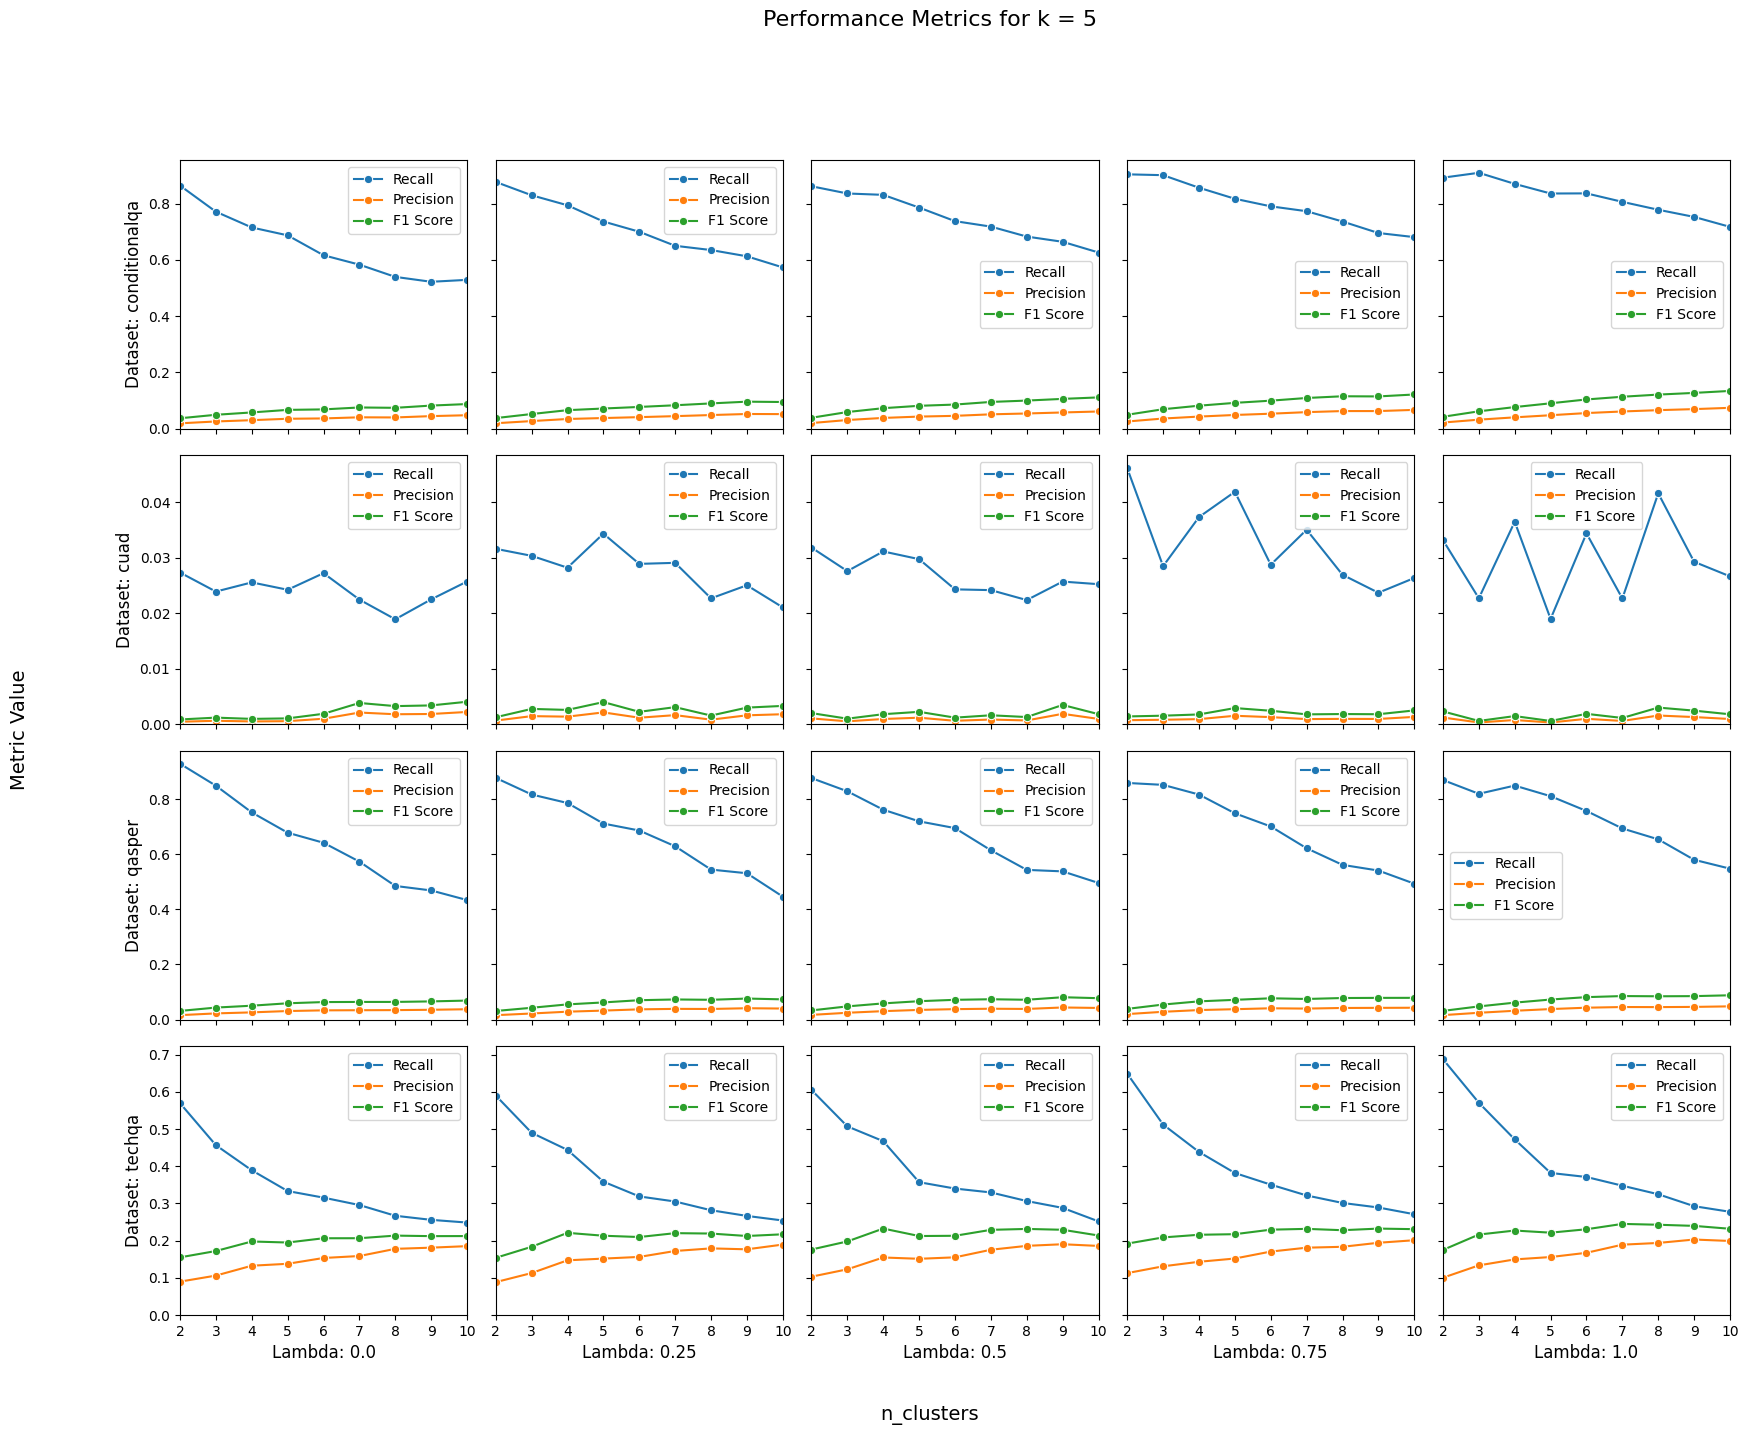

Showing plot for k=10


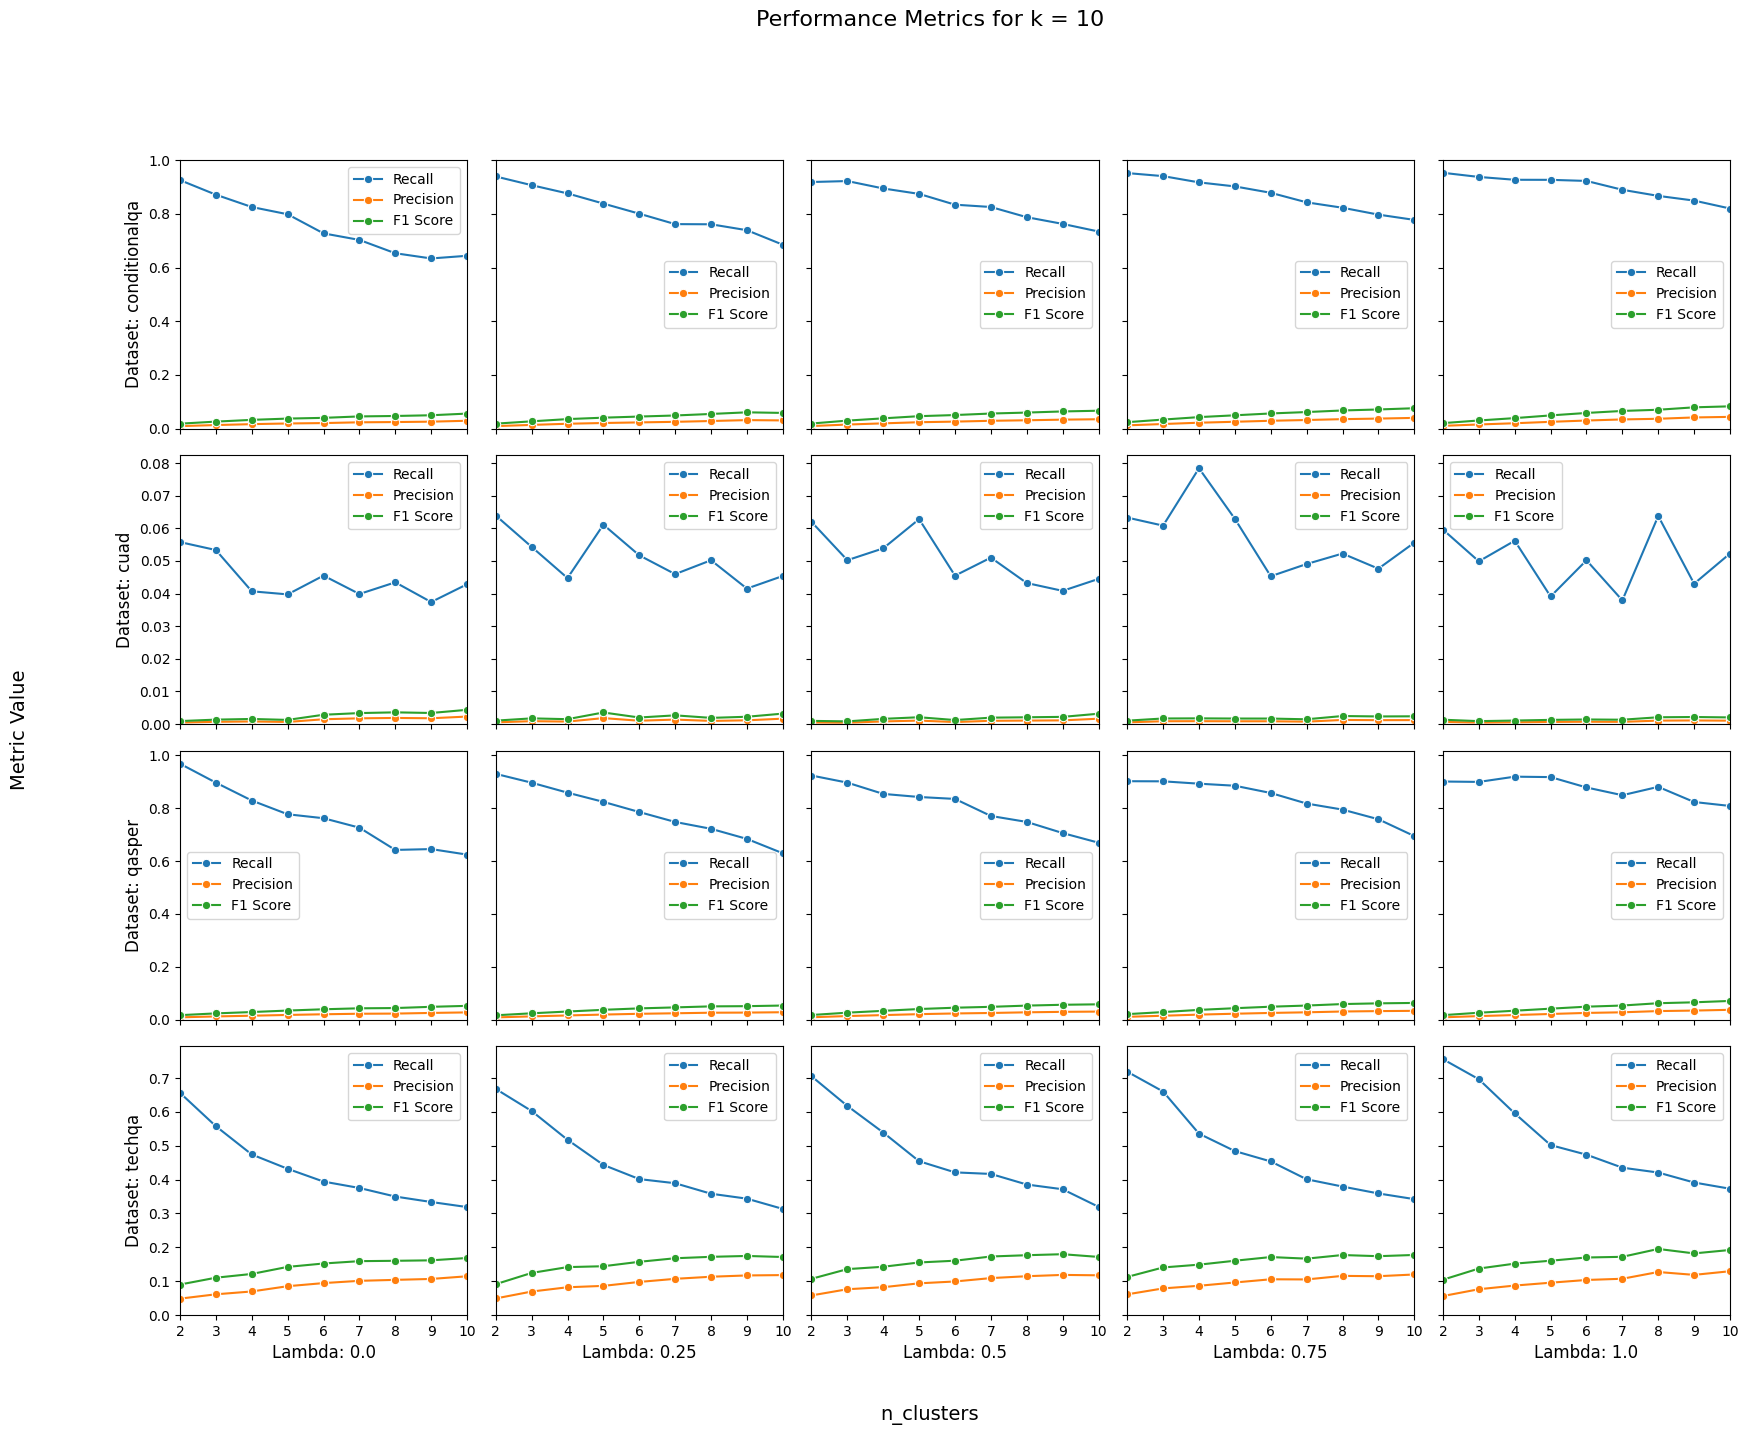

In [21]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'SingleLinkageChunker'
subset_df = get_chunker_df(df, chunker_name)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['lamda'] = subset_df['lamda'].astype(float)
subset_df['n_clusters'] = subset_df['n_clusters'].astype(int)

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
lamda_values = sorted(subset_df['lamda'].unique())

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(lamda_values),
                             figsize=(20, 15), sharex=True, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, lamda in enumerate(lamda_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['lamda'] == lamda]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='n_clusters', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='n_clusters', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='n_clusters', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xlim(2, 10)
            ax.set_xticks(range(2, 11))

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, lamda in enumerate(lamda_values):
        axes[-1, j].set_xlabel(f'Lambda: {lamda}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    fig.text(0.5, 0.04, 'n_clusters', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()

### lambda

Showing plot for k=1


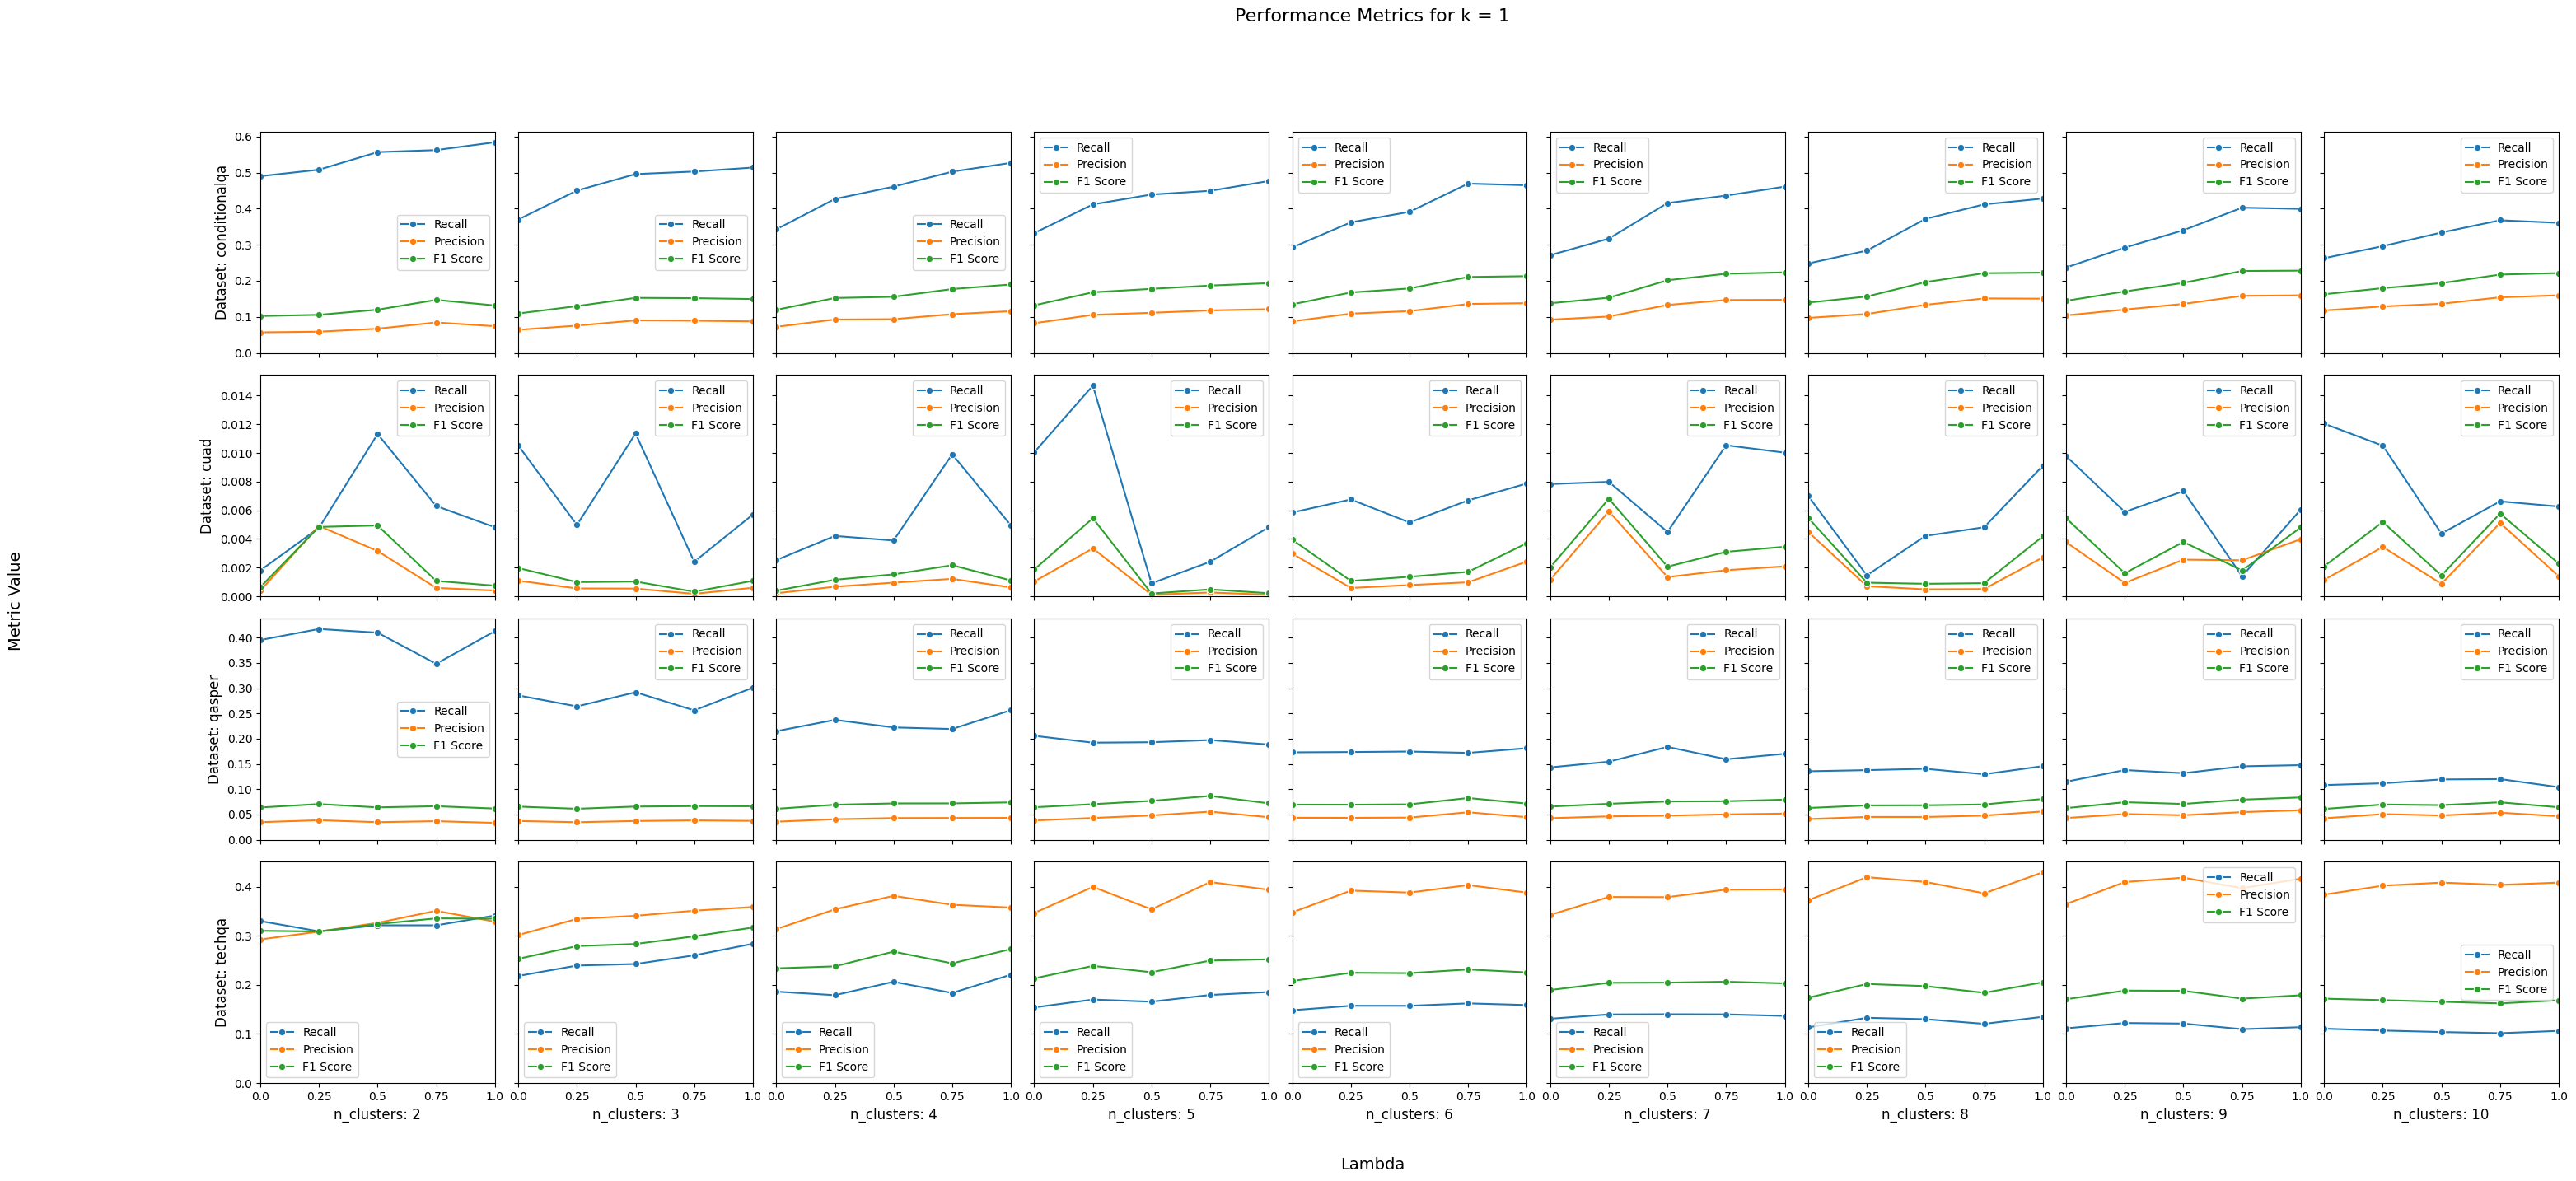

Showing plot for k=3


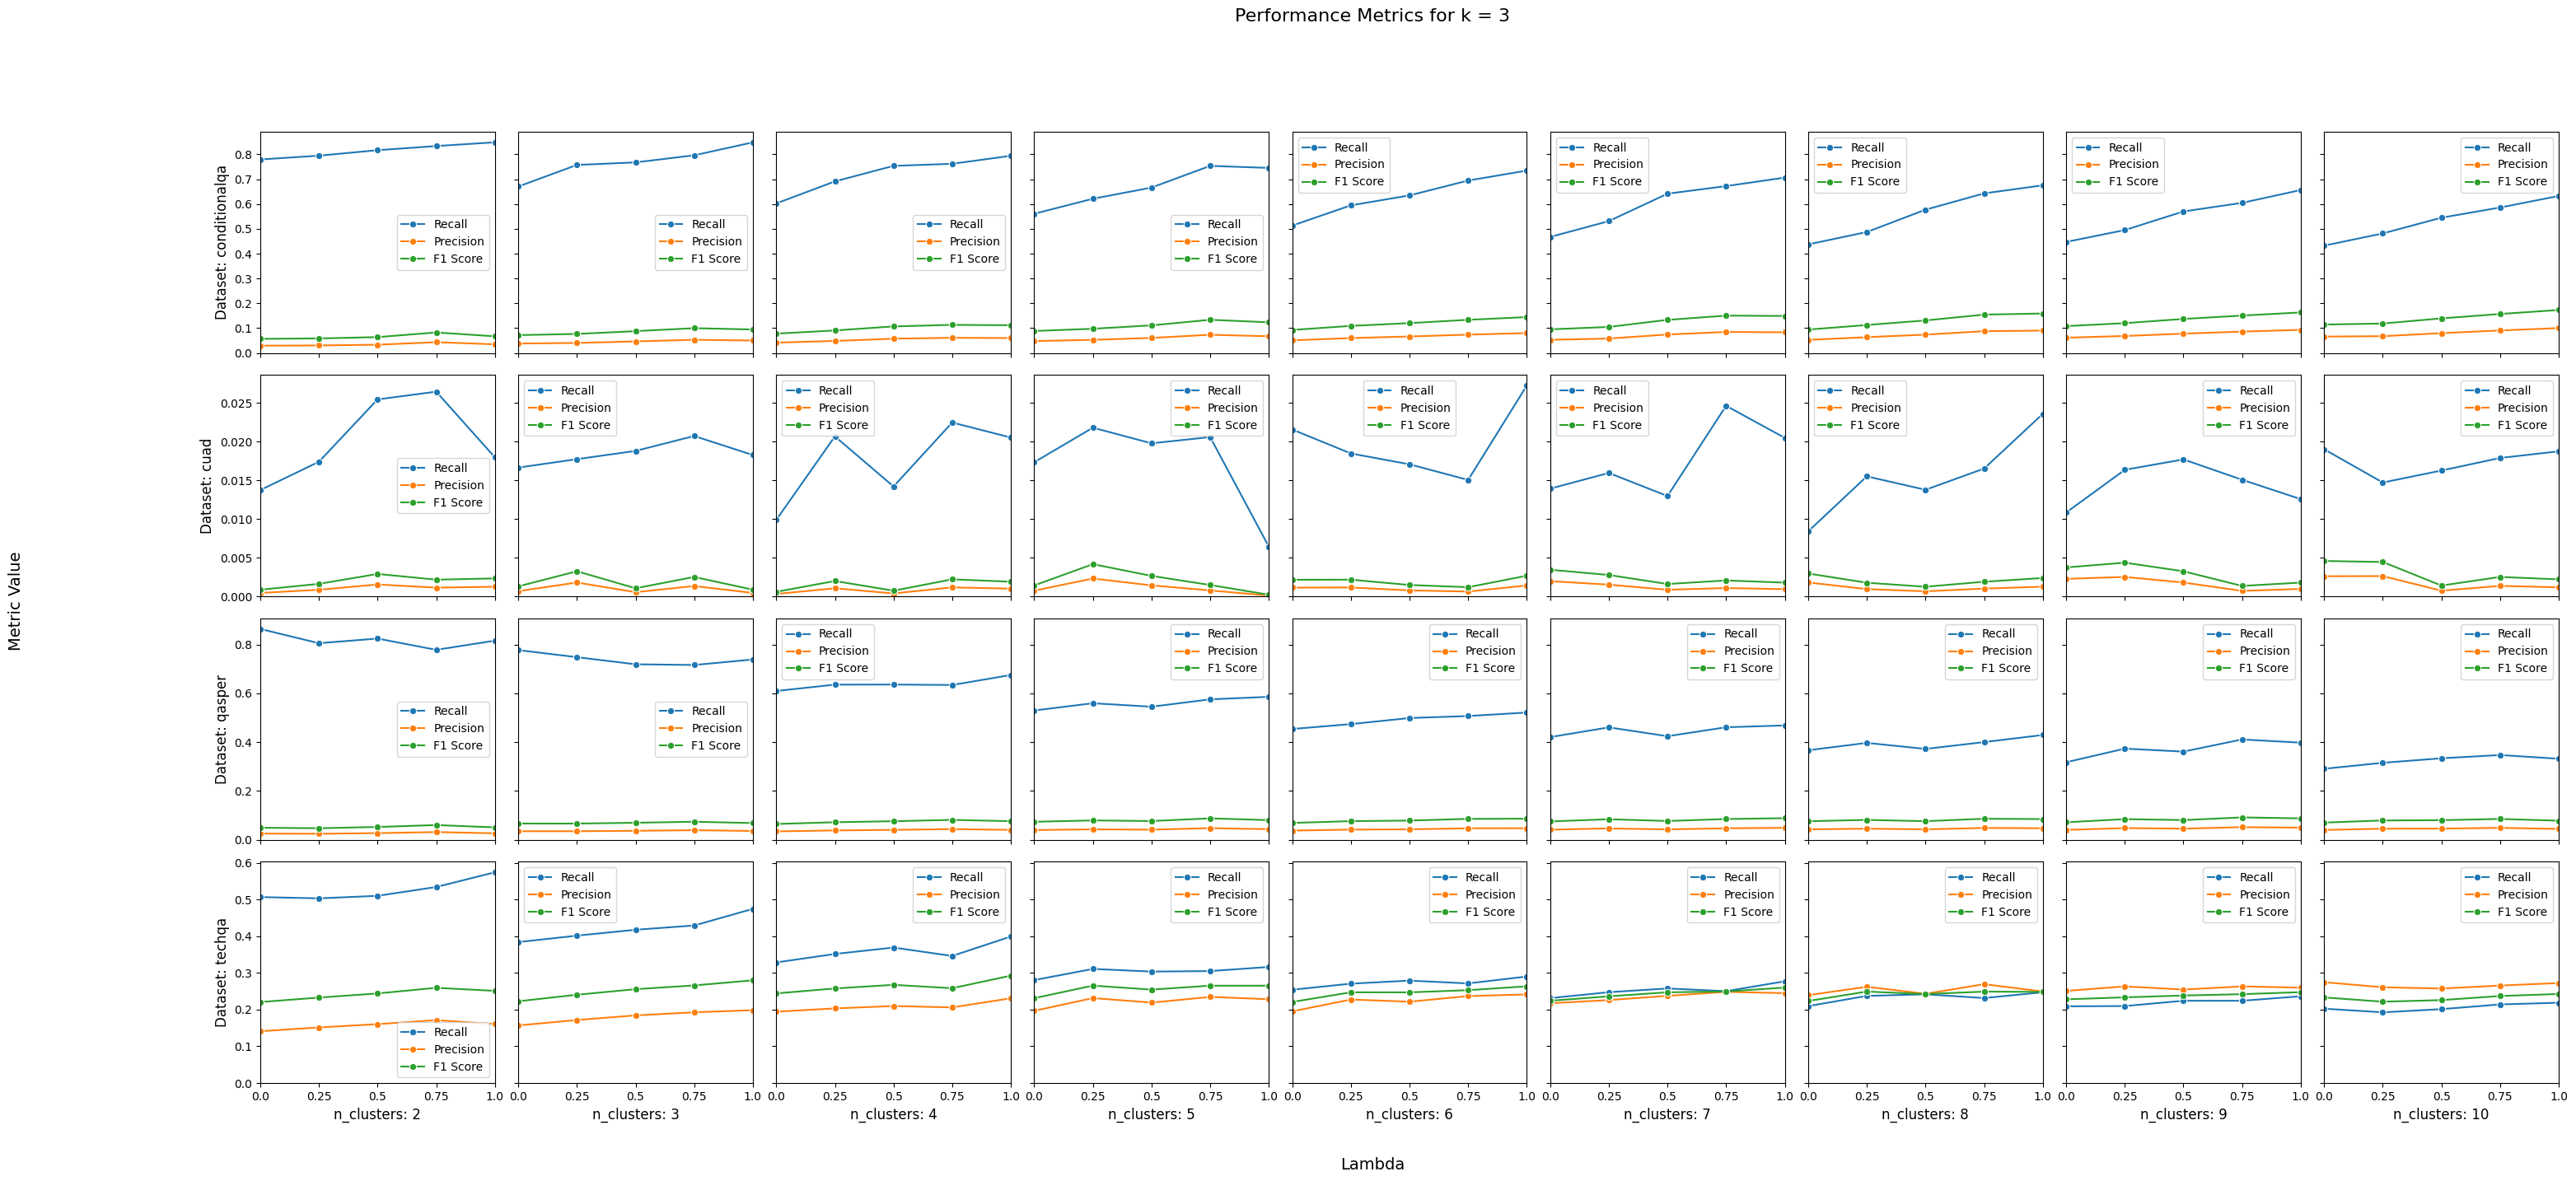

Showing plot for k=5


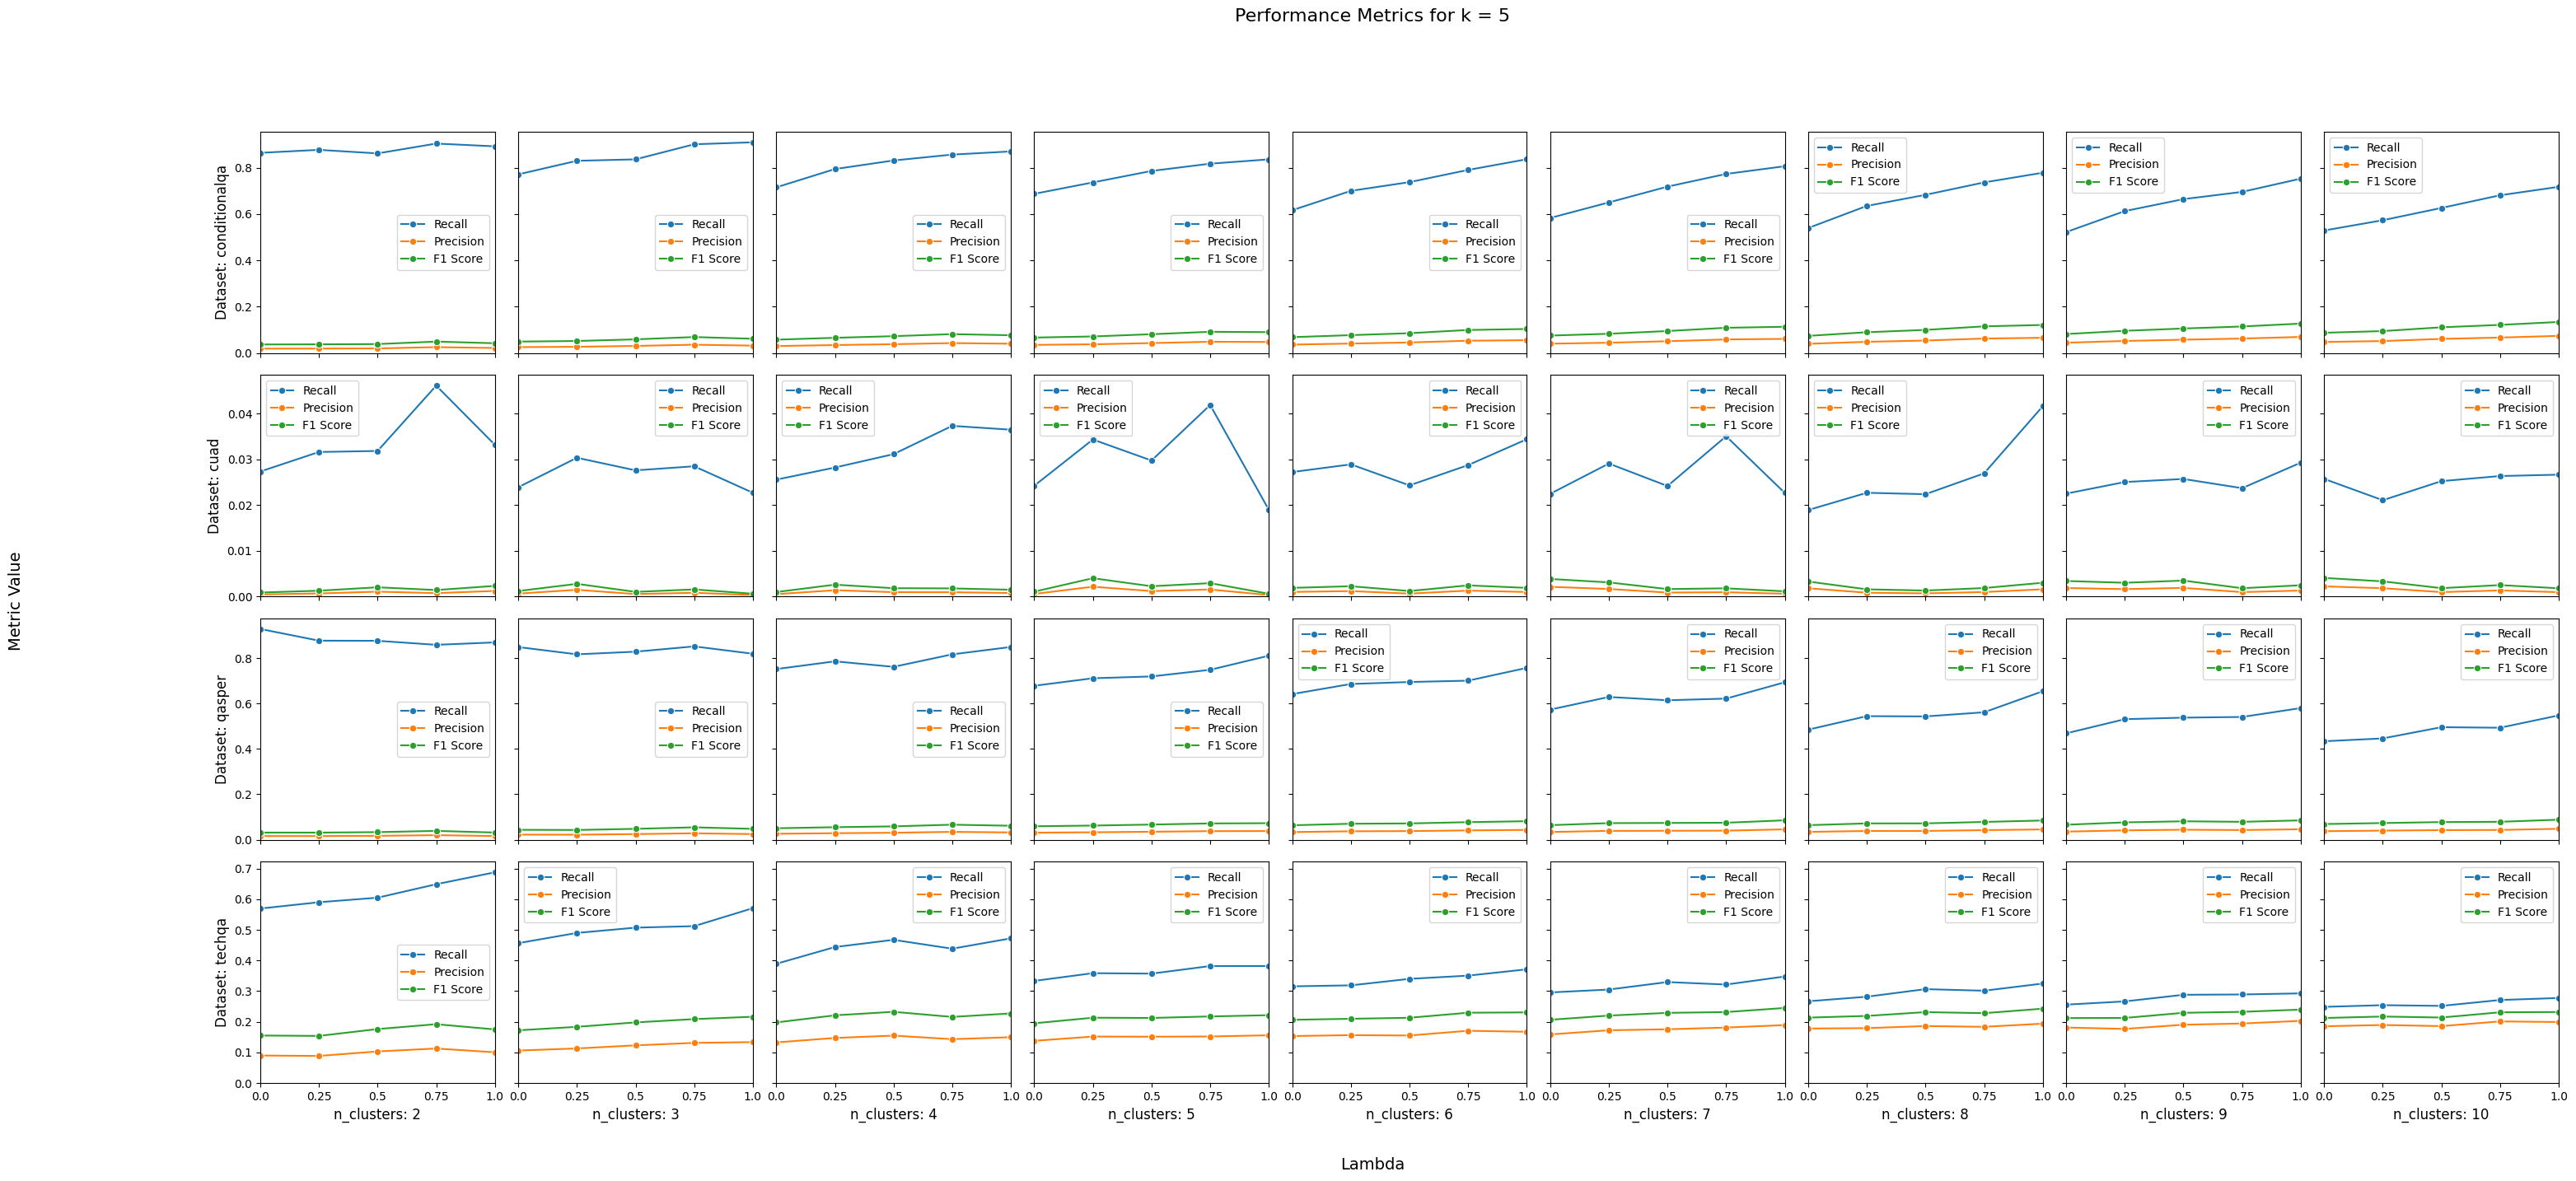

Showing plot for k=10


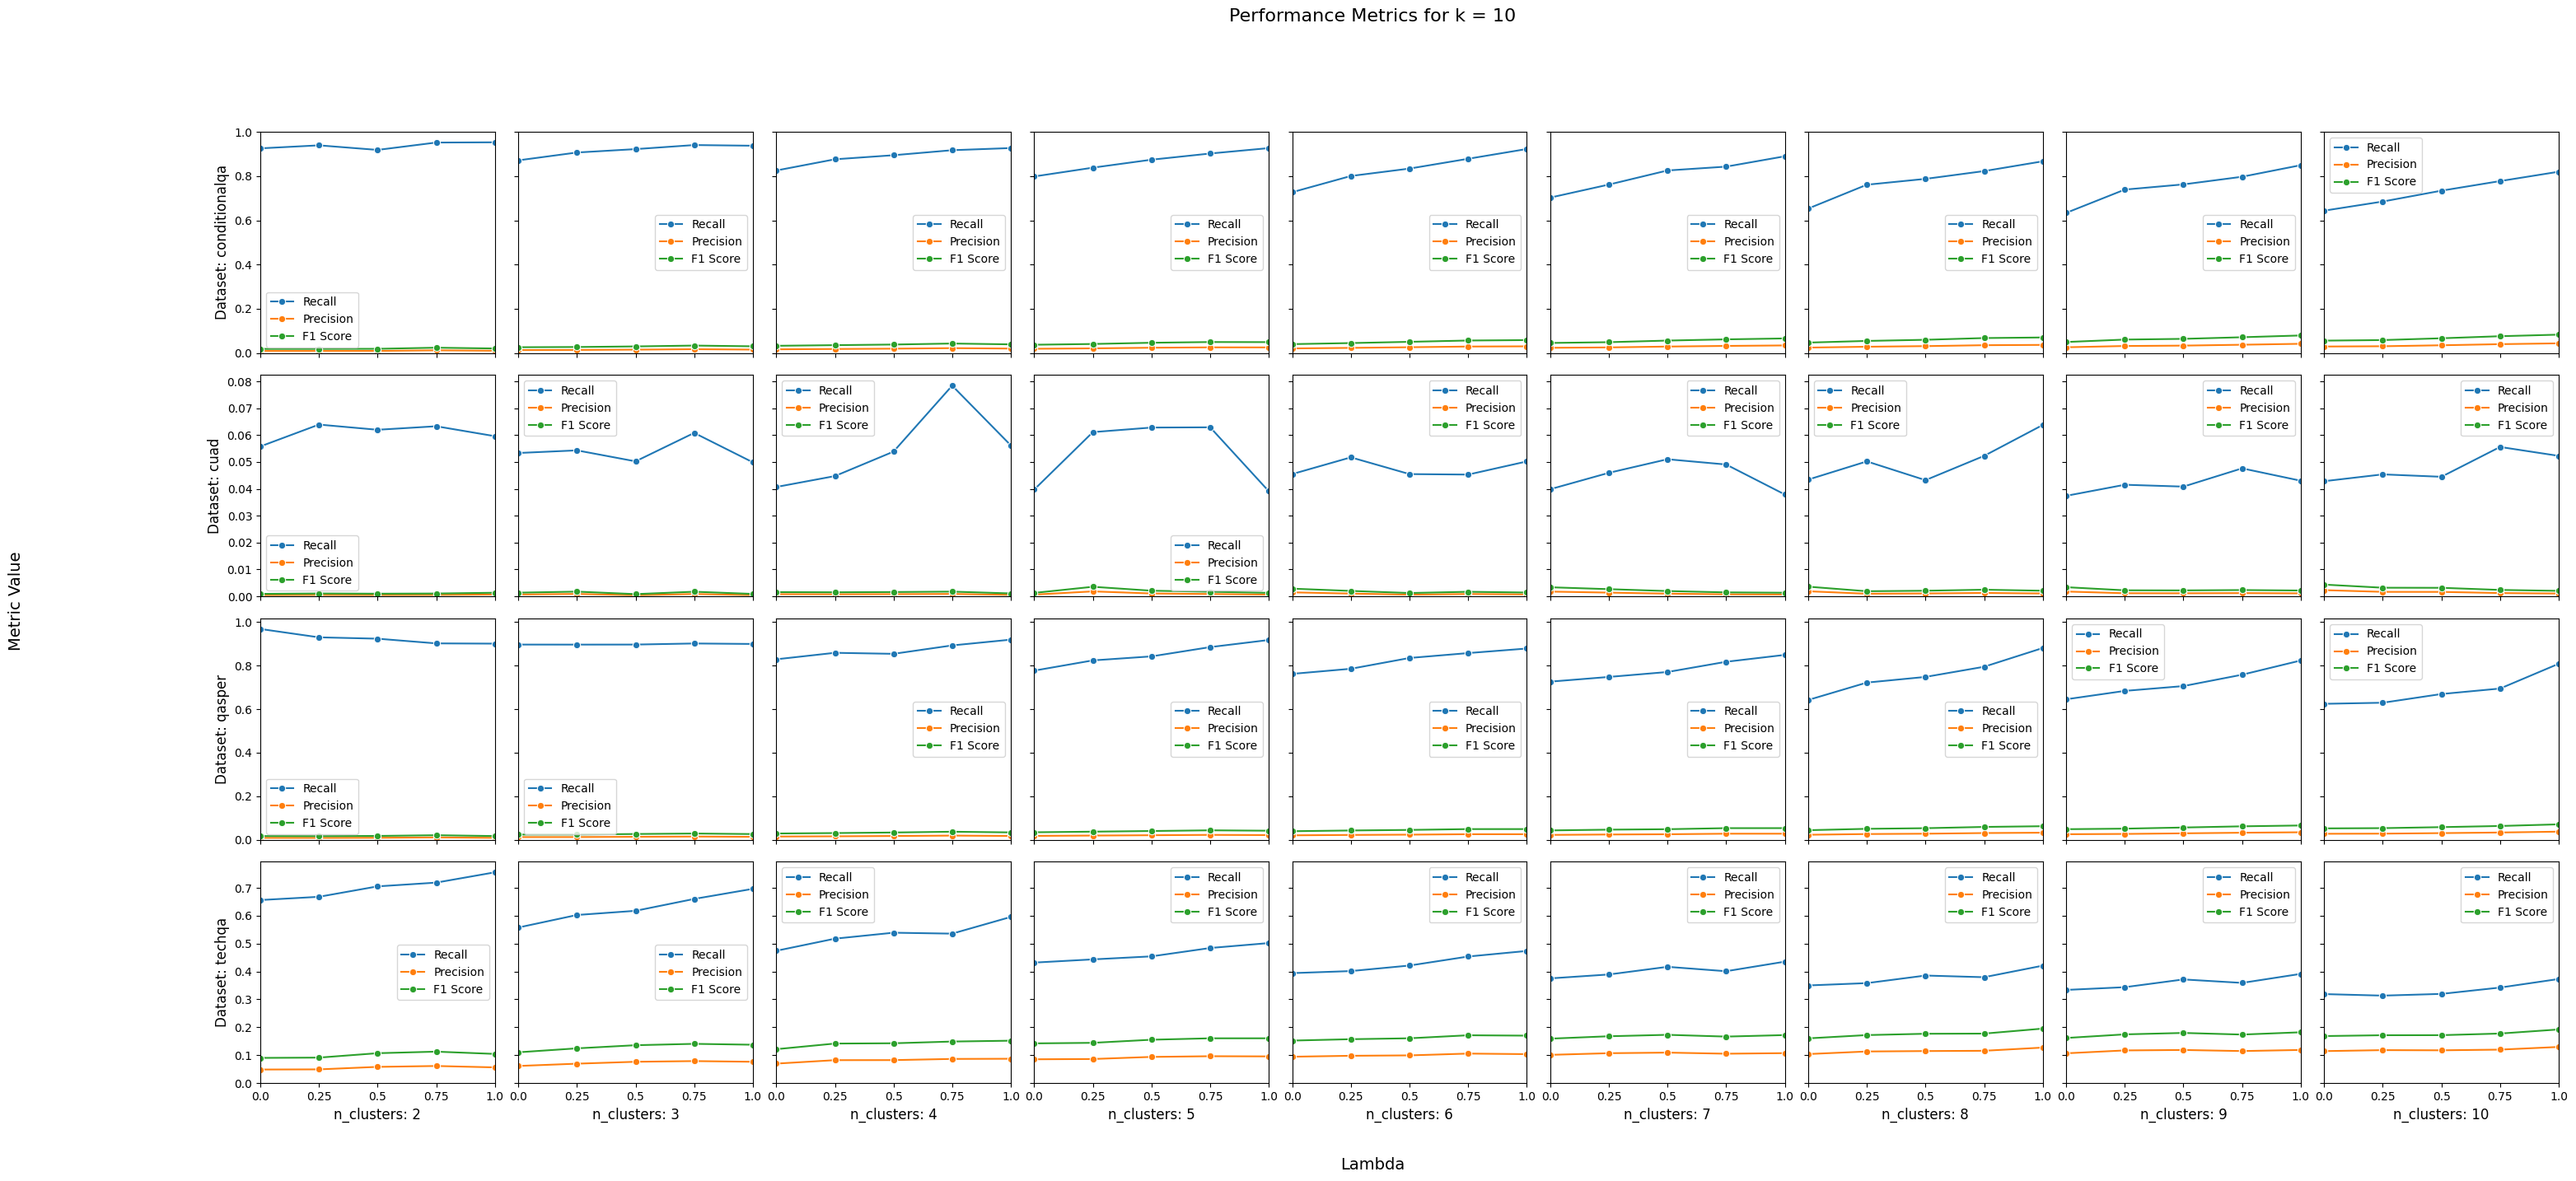

In [22]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'SingleLinkageChunker'
subset_df = get_chunker_df(df, chunker_name)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['lamda'] = subset_df['lamda'].astype(float)
subset_df['n_clusters'] = subset_df['n_clusters'].astype(int)

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
# lamda_values = sorted(subset_df['lamda'].unique())
n_clusters_values = sorted(subset_df['n_clusters'].unique())

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(n_clusters_values),
                             figsize=(36, 15), sharex=True, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, n_clusters in enumerate(n_clusters_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['n_clusters'] == n_clusters]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='lamda', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='lamda', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='lamda', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xlim(0, 1)
            ax.set_xticks(lamda_values, lamda_values)

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, n_clusters in enumerate(n_clusters_values):
        axes[-1, j].set_xlabel(f'n_clusters: {n_clusters}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    fig.text(0.5, 0.04, 'Lambda', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()

## DBSCANChunker

There are too many hyperparameter combinations for DBSCAN. The following plots use `lambda = 0.5`. If you wish to change the lambda value, change below:

In [23]:
lamda_for_visualization = 0.5

### EPS

Showing plot for k=1


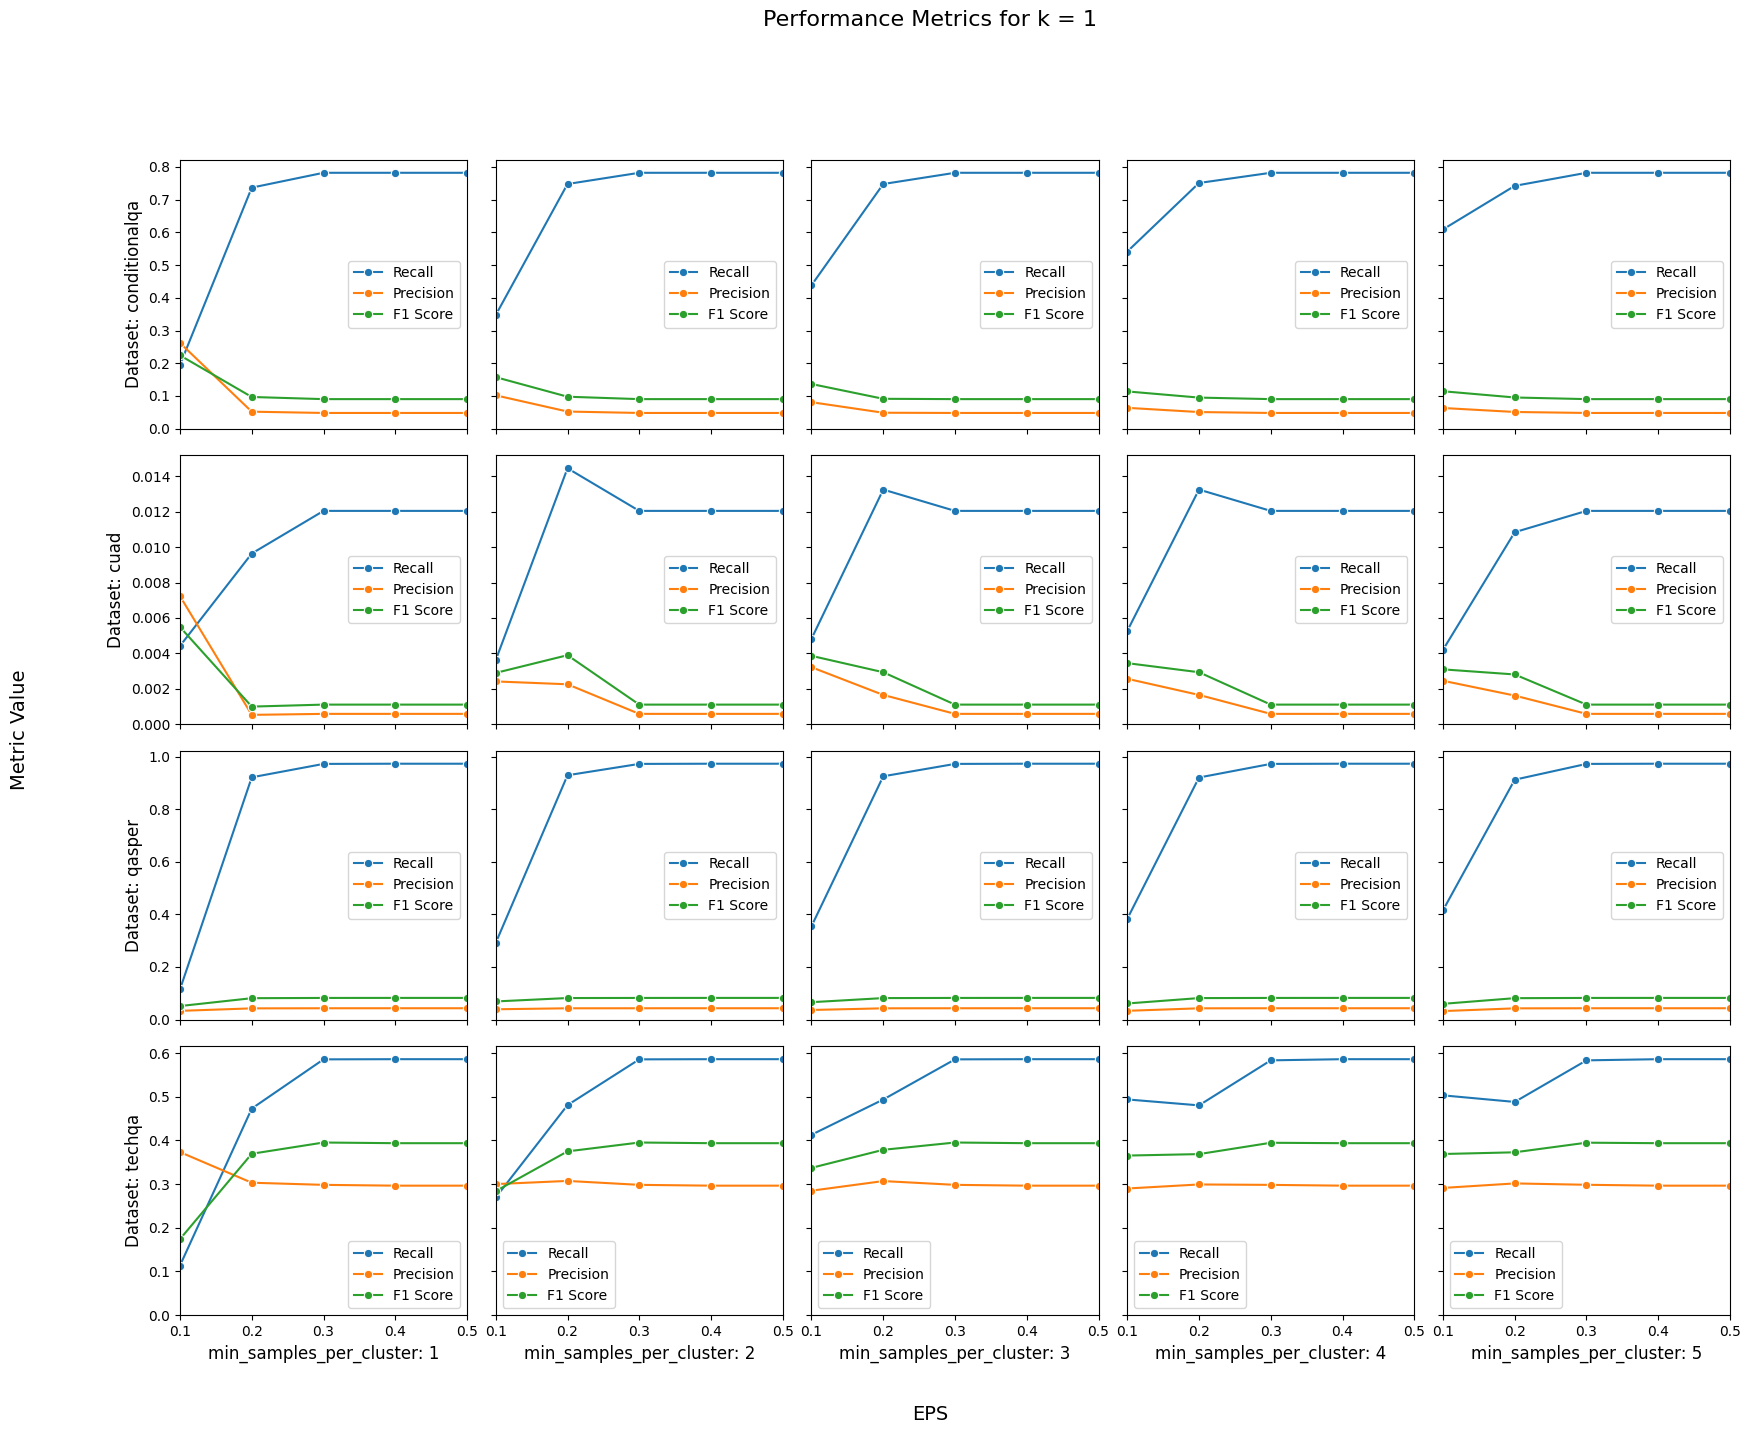

Showing plot for k=3


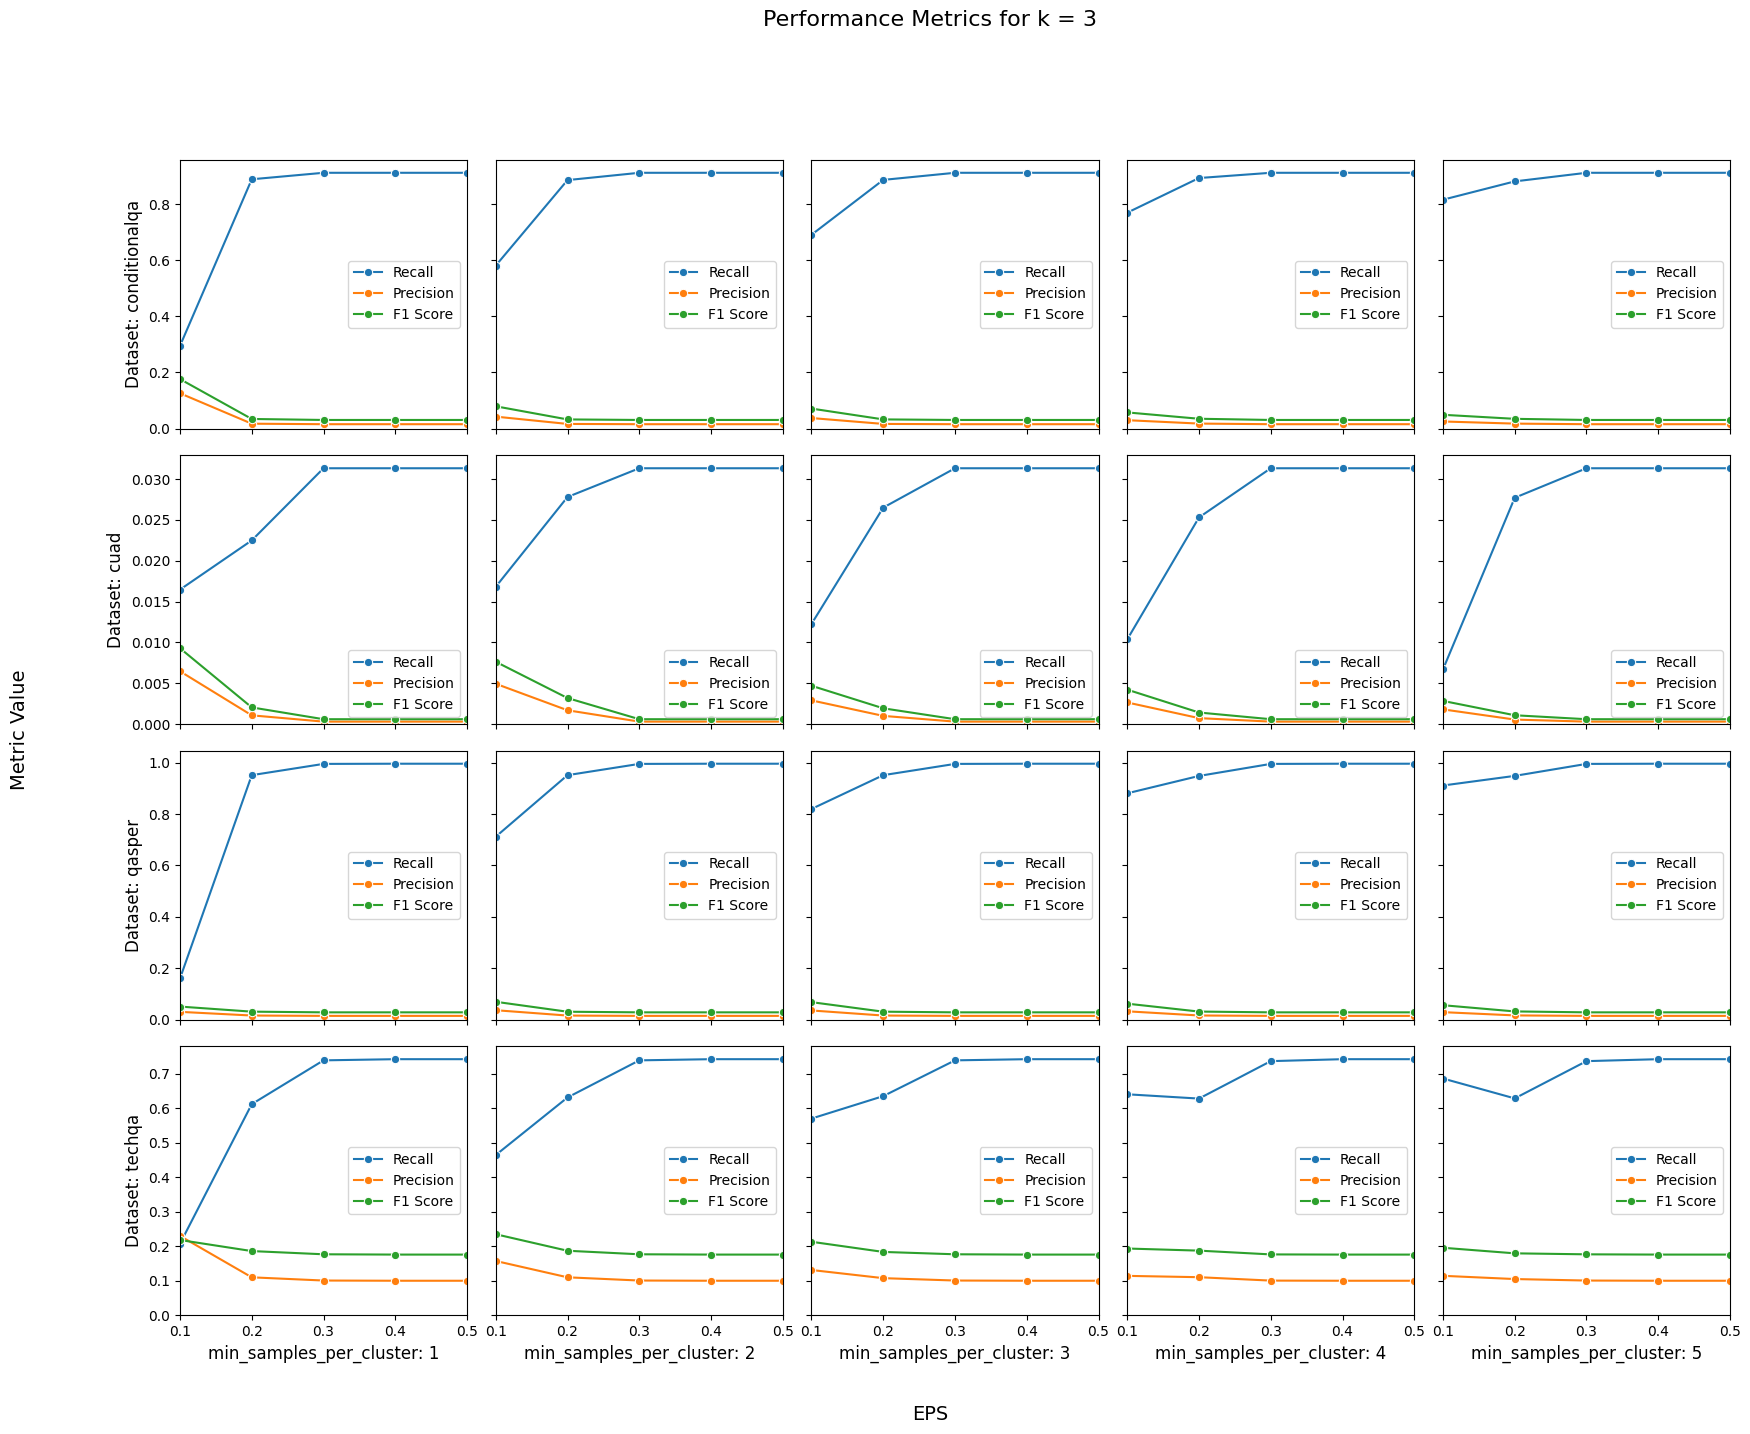

Showing plot for k=5


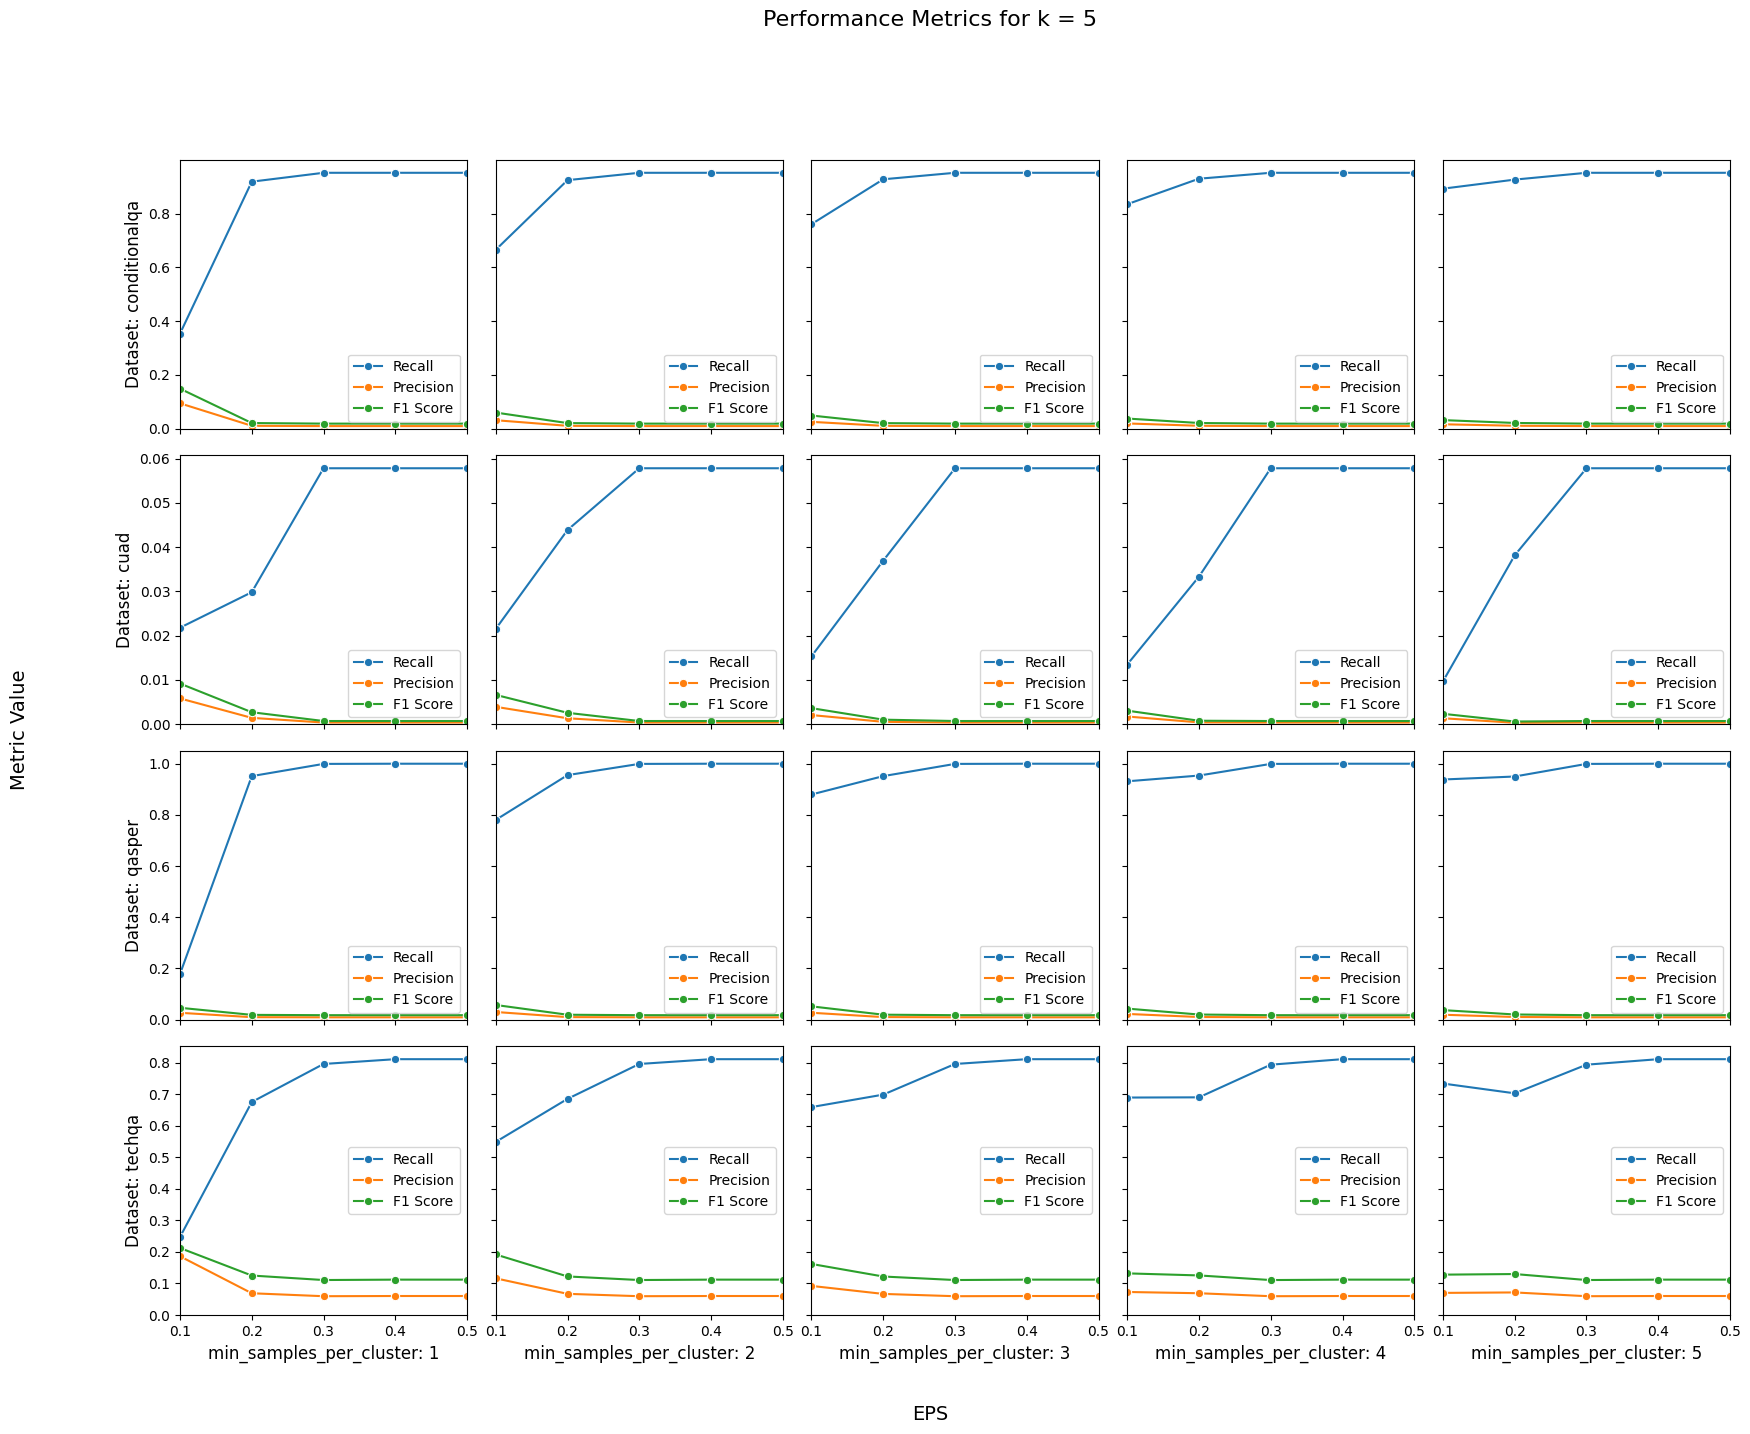

Showing plot for k=10


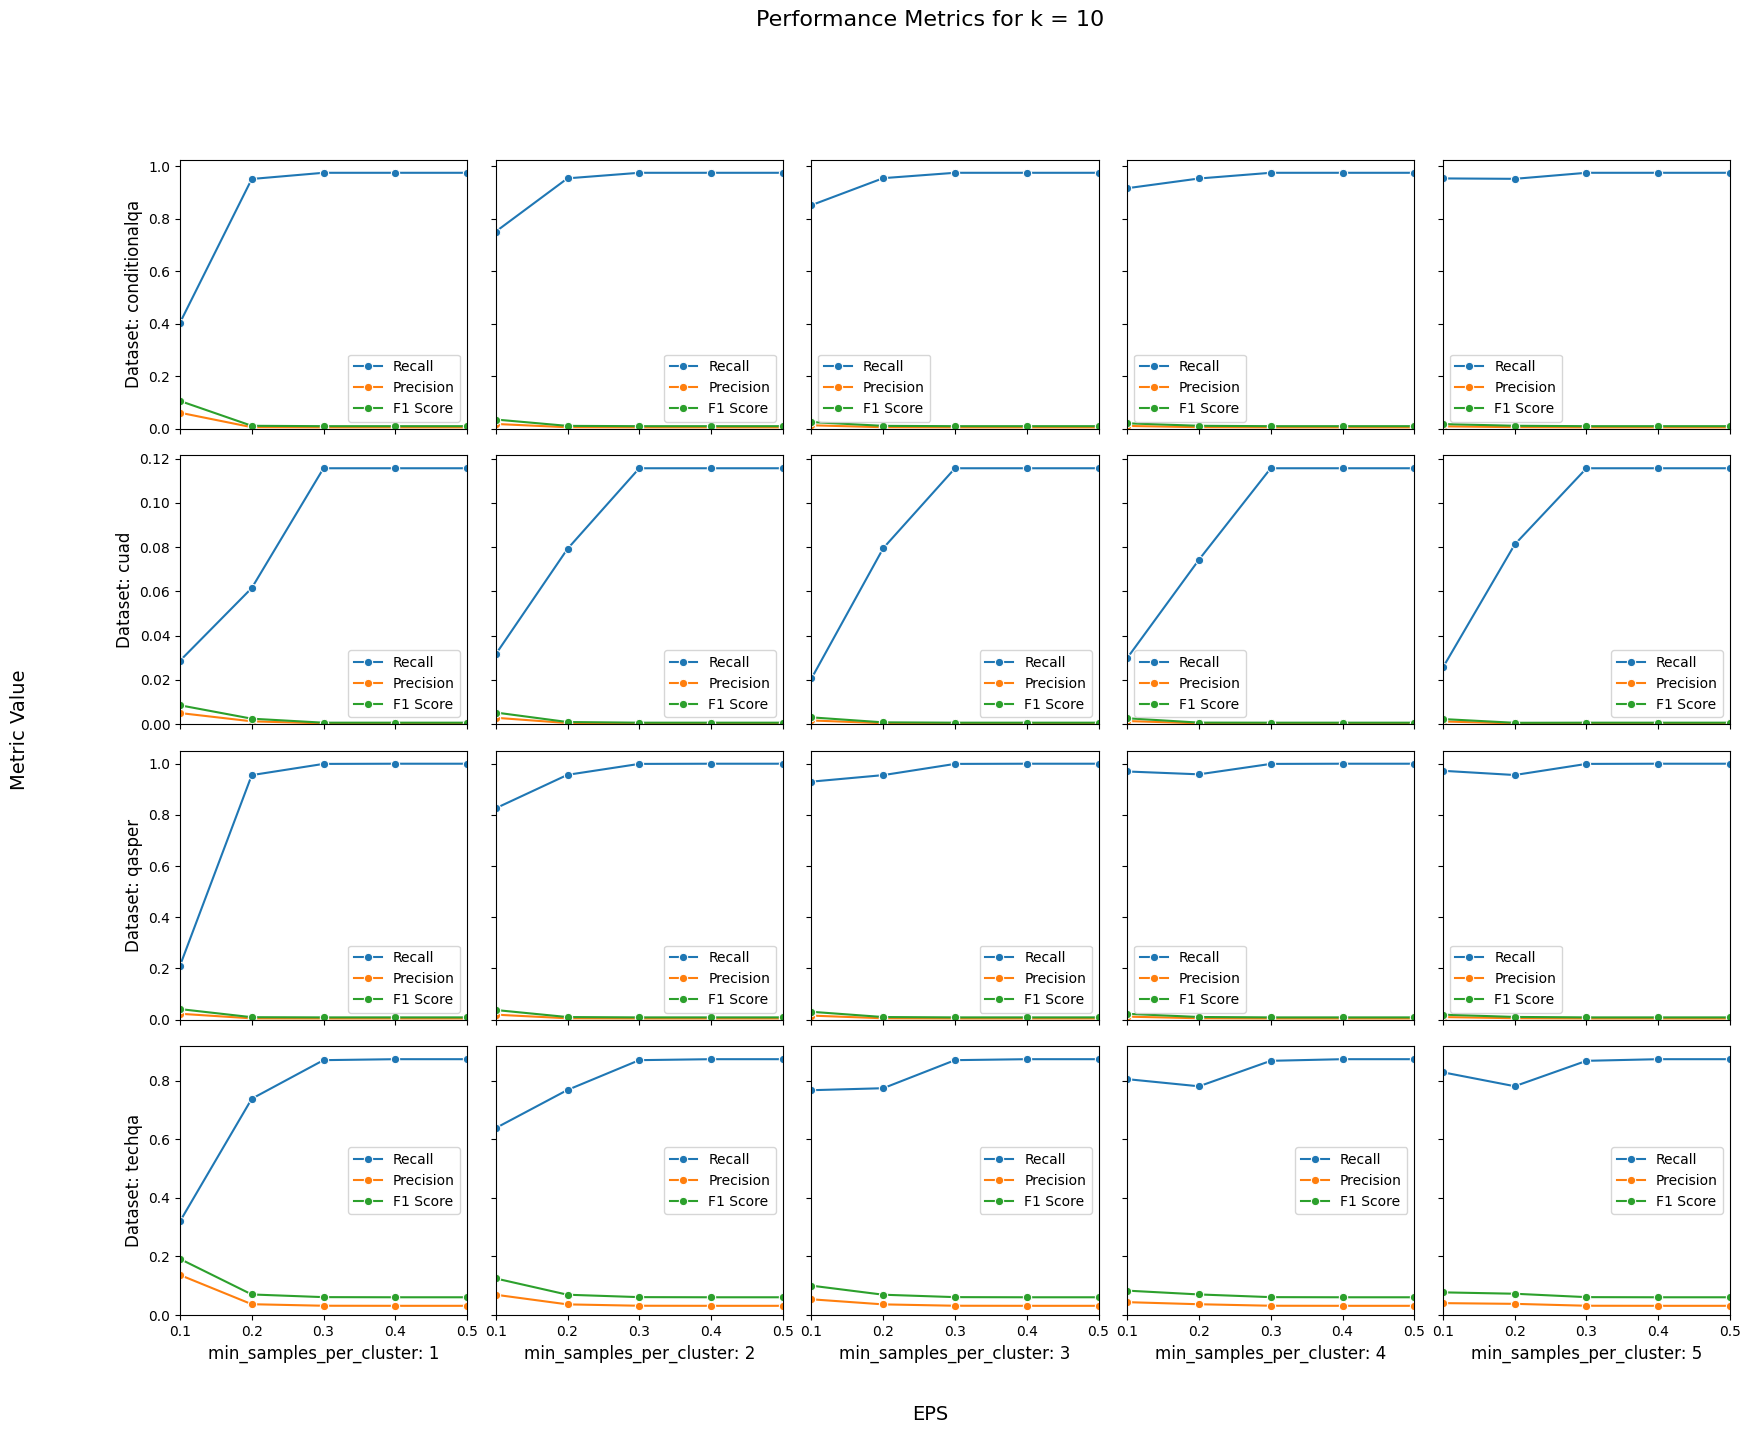

In [24]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'DBSCANChunker'
subset_df = get_chunker_df(df, chunker_name)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['lamda'] = subset_df['lamda'].astype(float)
subset_df['eps'] = subset_df['eps'].astype(float)
subset_df['min_samples_per_cluster'] = subset_df['min_samples_per_cluster'].astype(int)
subset_df = subset_df[subset_df['lamda'] == lamda_for_visualization]

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
eps_values = sorted(subset_df['eps'].unique())
min_samples_per_cluster_values = sorted(subset_df['min_samples_per_cluster'].unique())

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(min_samples_per_cluster_values),
                             figsize=(20, 15), sharex=True, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, min_samples_per_cluster in enumerate(min_samples_per_cluster_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['min_samples_per_cluster'] == min_samples_per_cluster]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='eps', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='eps', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='eps', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xlim(eps_values[0], eps_values[-1])
            ax.set_xticks(eps_values, eps_values)

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, min_samples_per_cluster in enumerate(min_samples_per_cluster_values):
        axes[-1, j].set_xlabel(f'min_samples_per_cluster: {min_samples_per_cluster}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    fig.text(0.5, 0.04, 'EPS', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()

Showing plot for k=1


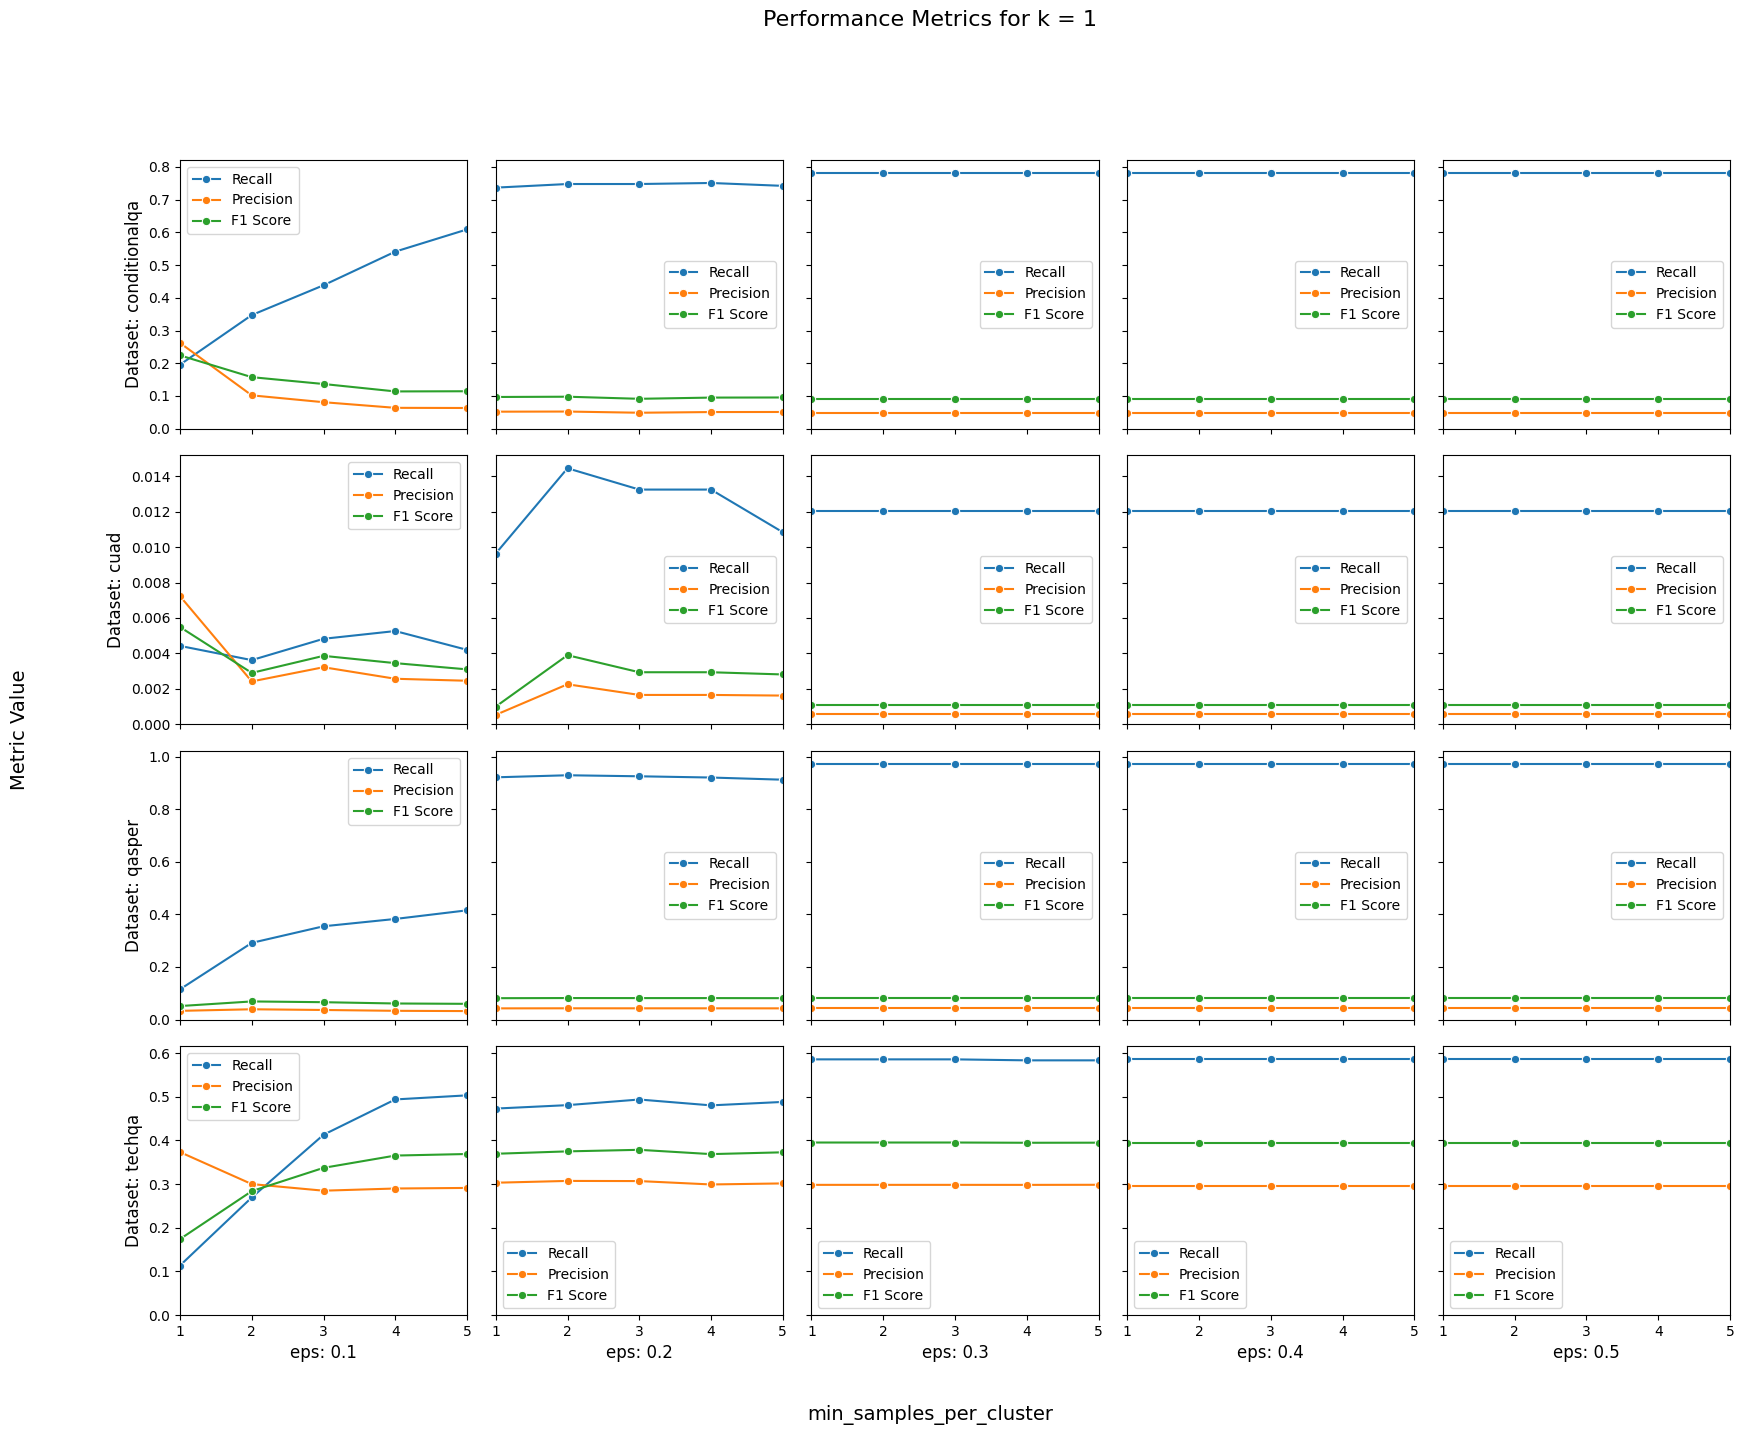

Showing plot for k=3


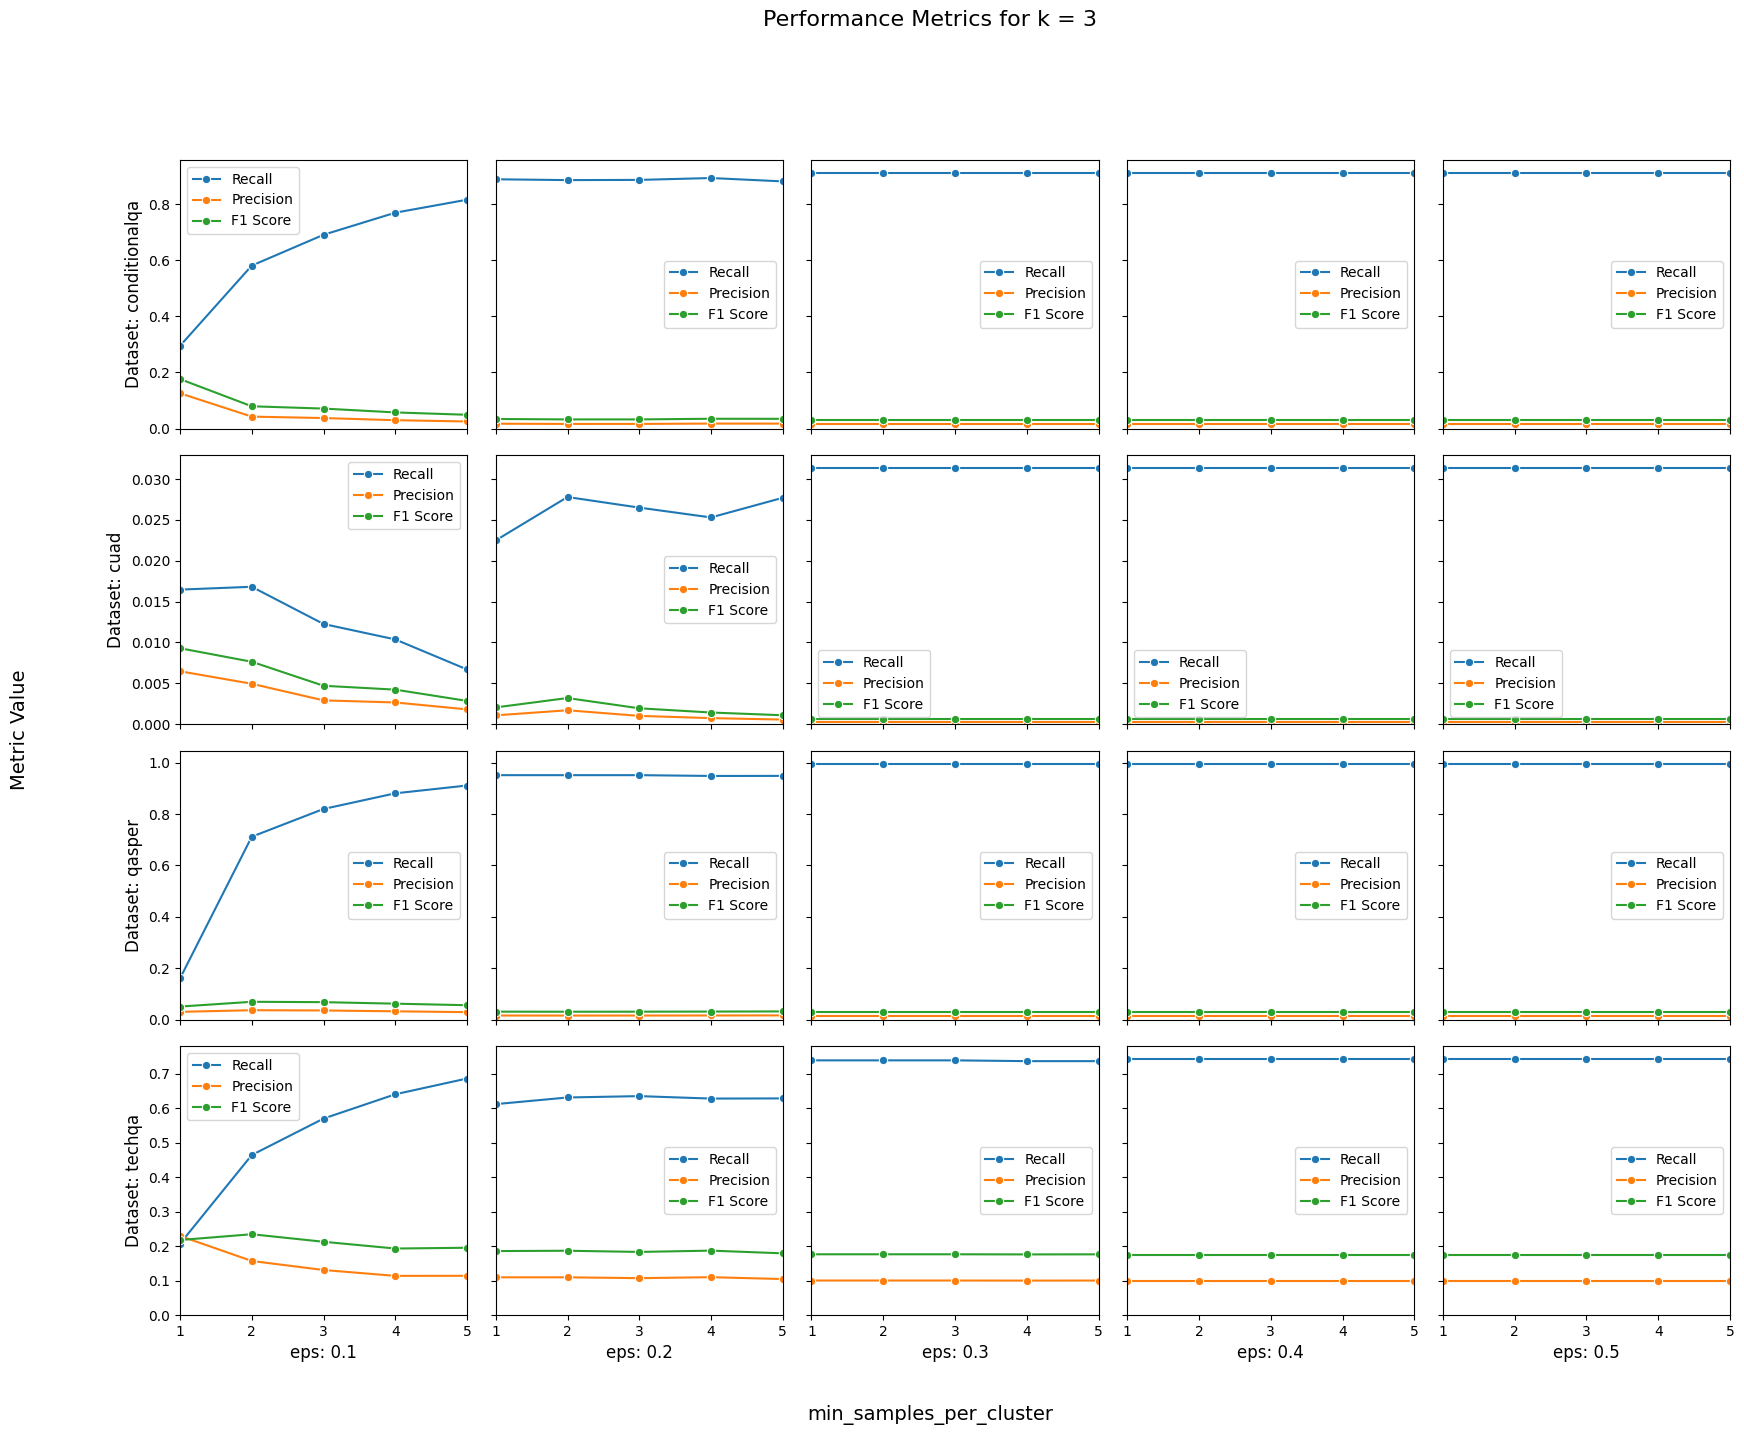

Showing plot for k=5


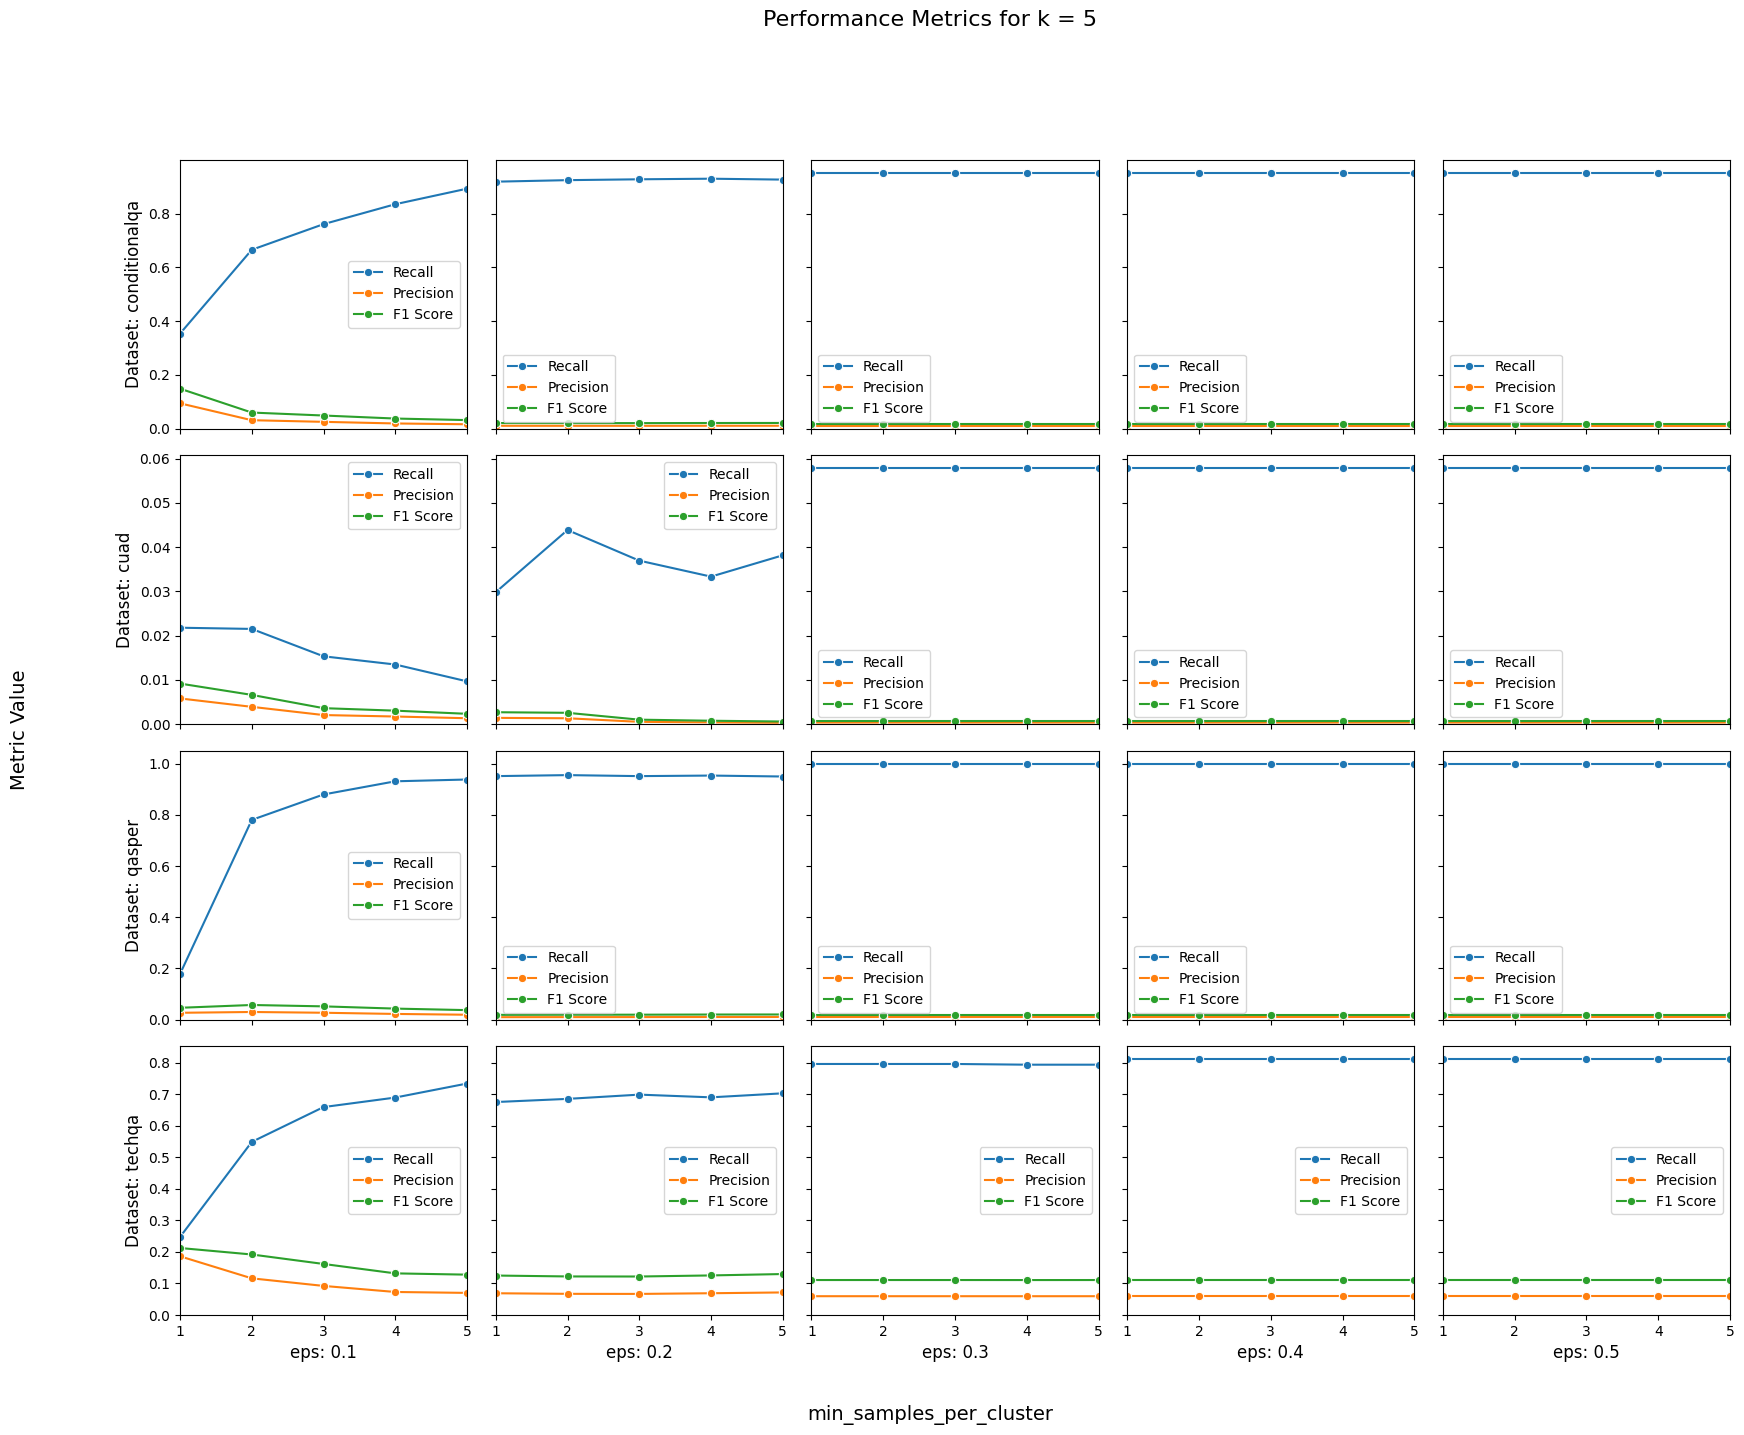

Showing plot for k=10


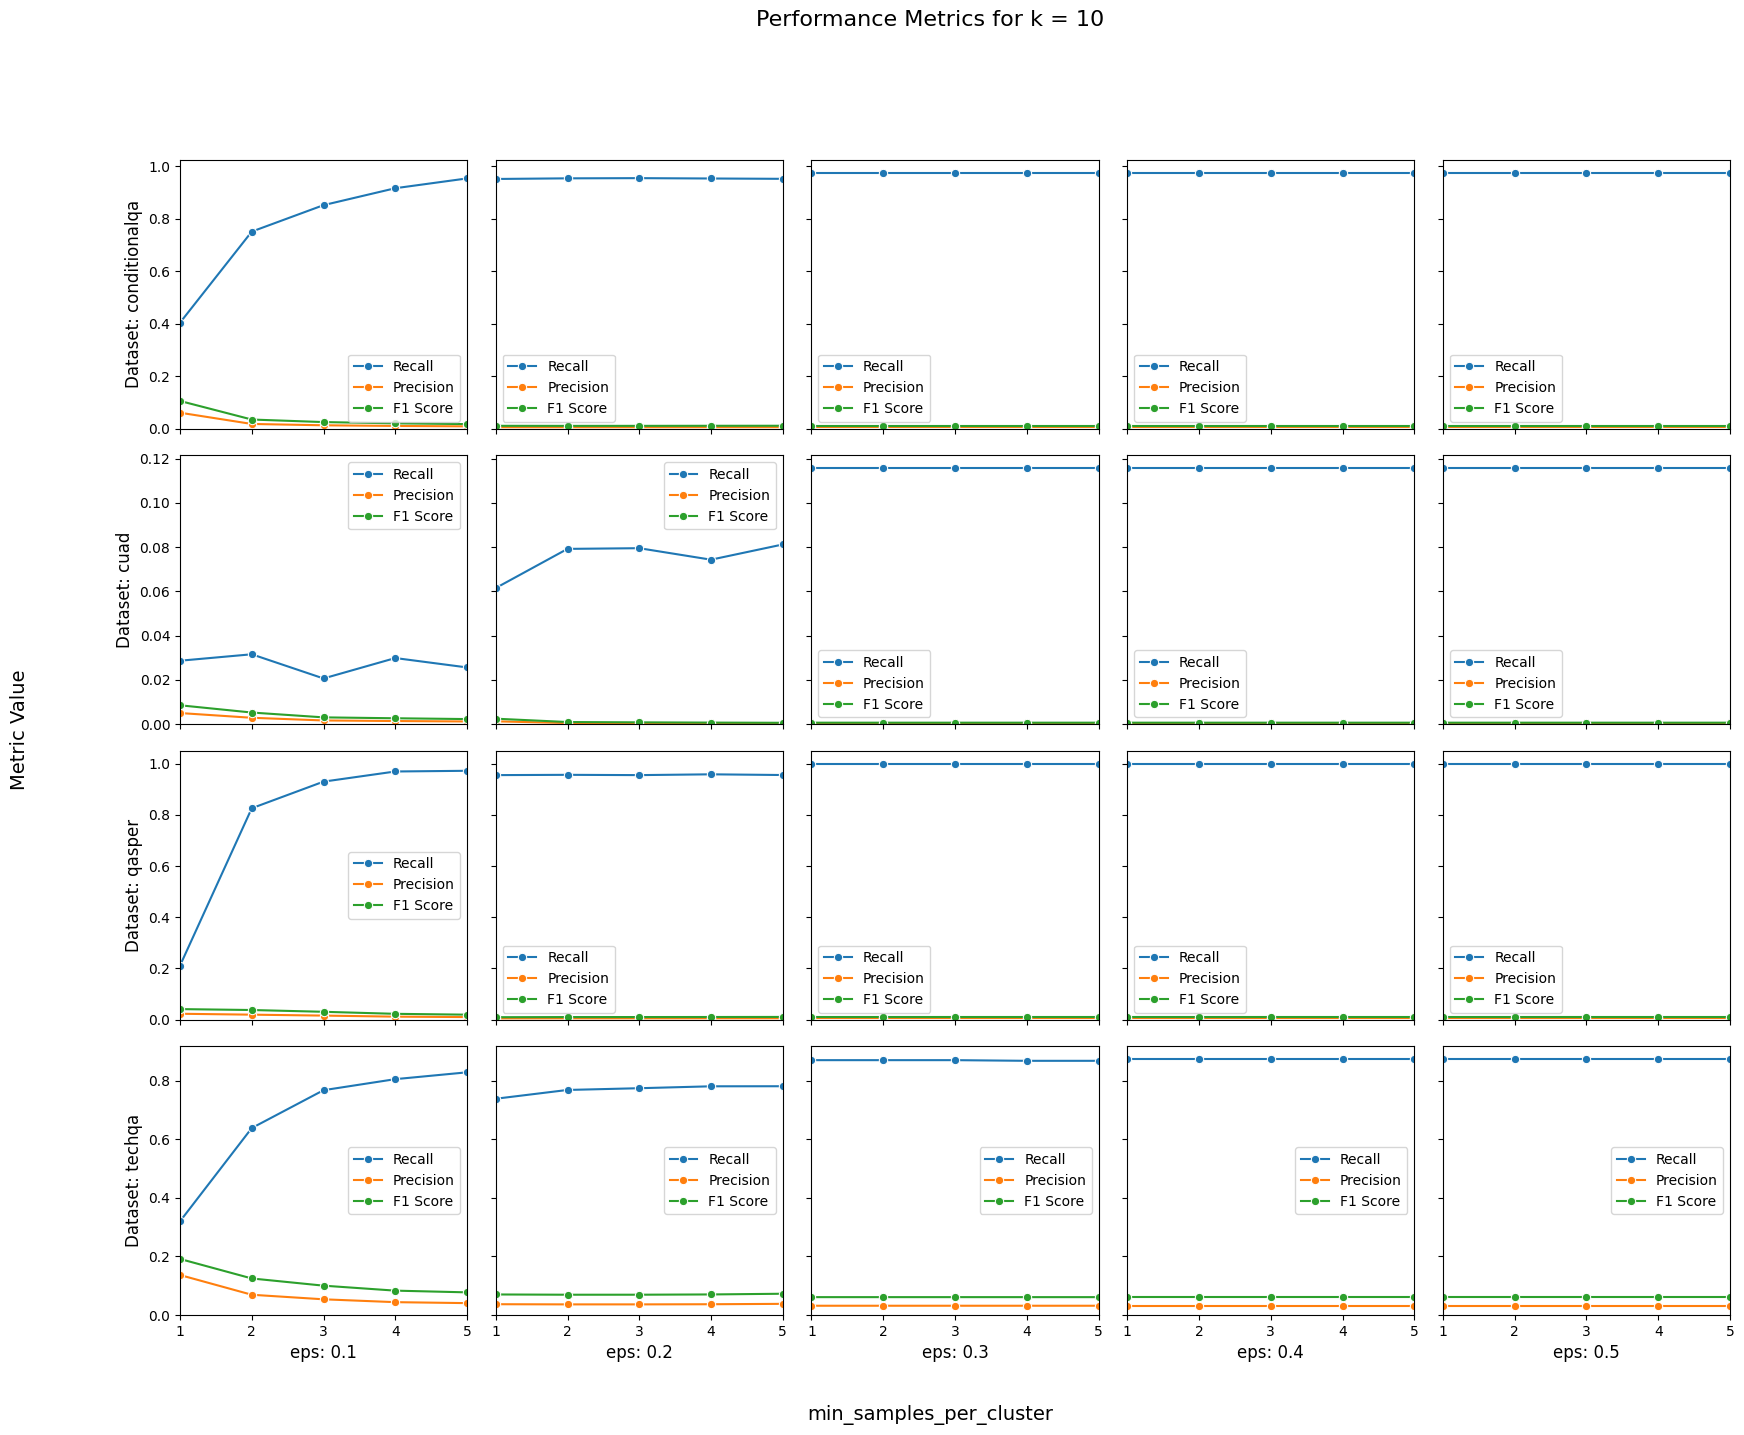

In [25]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'DBSCANChunker'
subset_df = get_chunker_df(df, chunker_name)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['lamda'] = subset_df['lamda'].astype(float)
subset_df['eps'] = subset_df['eps'].astype(float)
subset_df['min_samples_per_cluster'] = subset_df['min_samples_per_cluster'].astype(int)
subset_df = subset_df[subset_df['lamda'] == lamda_for_visualization]

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
eps_values = sorted(subset_df['eps'].unique())
min_samples_per_cluster_values = sorted(subset_df['min_samples_per_cluster'].unique())

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(eps_values),
                             figsize=(20, 15), sharex=True, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, eps in enumerate(eps_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['eps'] == eps]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='min_samples_per_cluster', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='min_samples_per_cluster', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='min_samples_per_cluster', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xlim(min_samples_per_cluster_values[0], min_samples_per_cluster_values[-1])
            ax.set_xticks(min_samples_per_cluster_values, min_samples_per_cluster_values)

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, eps in enumerate(eps_values):
        axes[-1, j].set_xlabel(f'eps: {eps}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    fig.text(0.5, 0.04, 'min_samples_per_cluster', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()

## PositionalChunker

### n_chunks

Showing plot for k=1


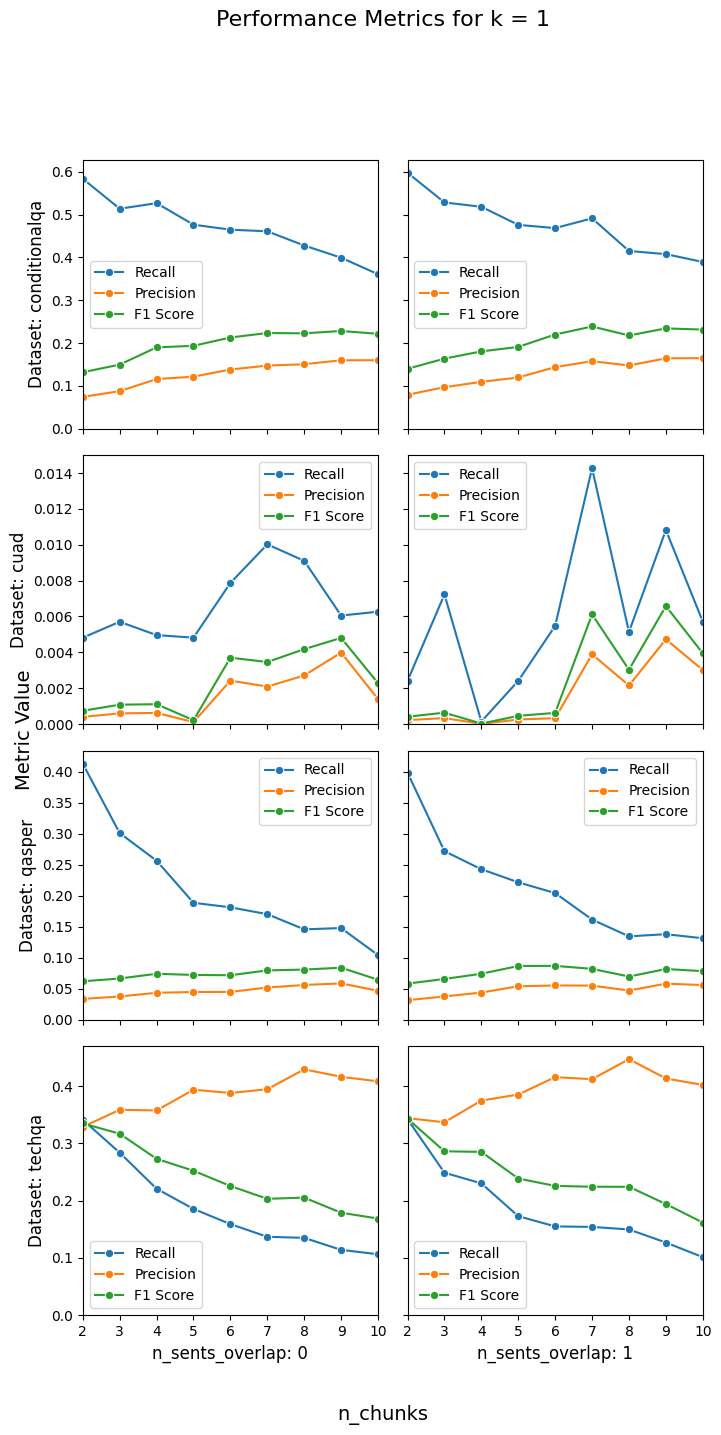

Showing plot for k=3


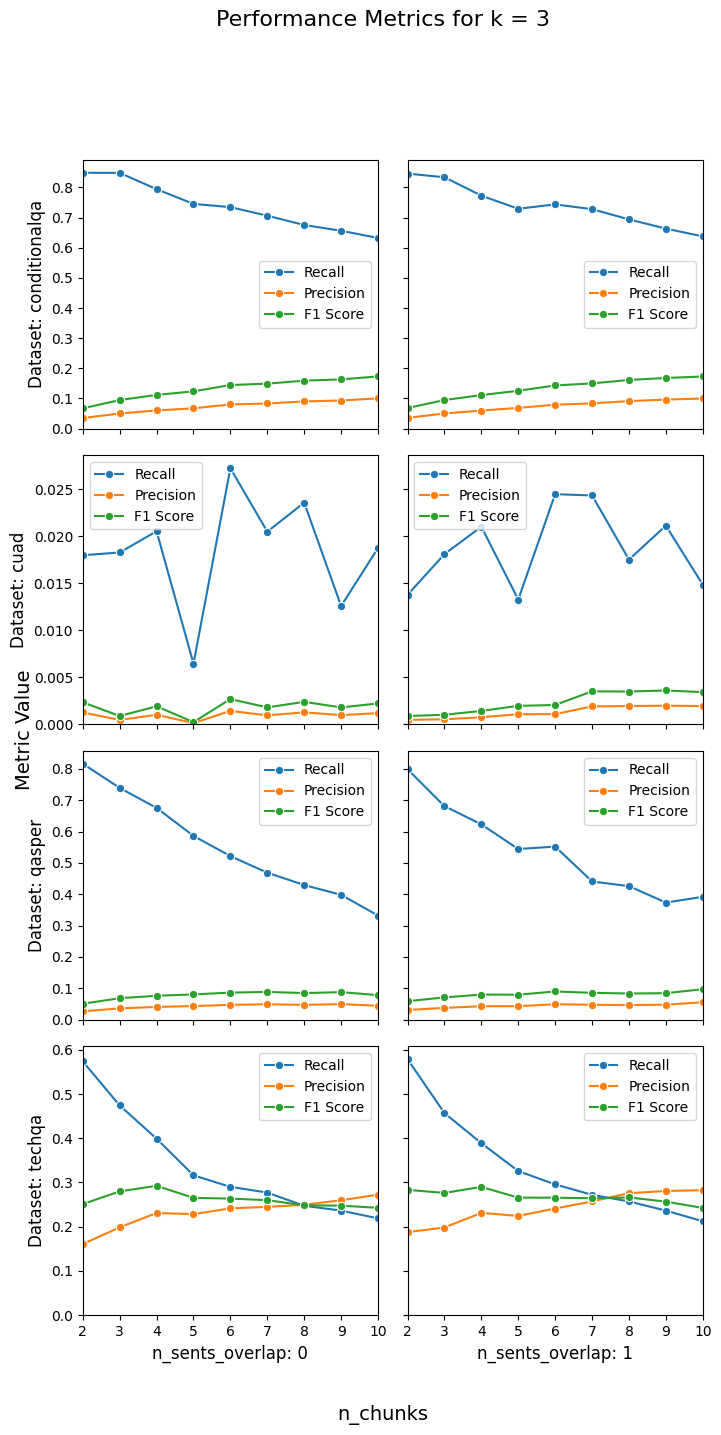

Showing plot for k=5


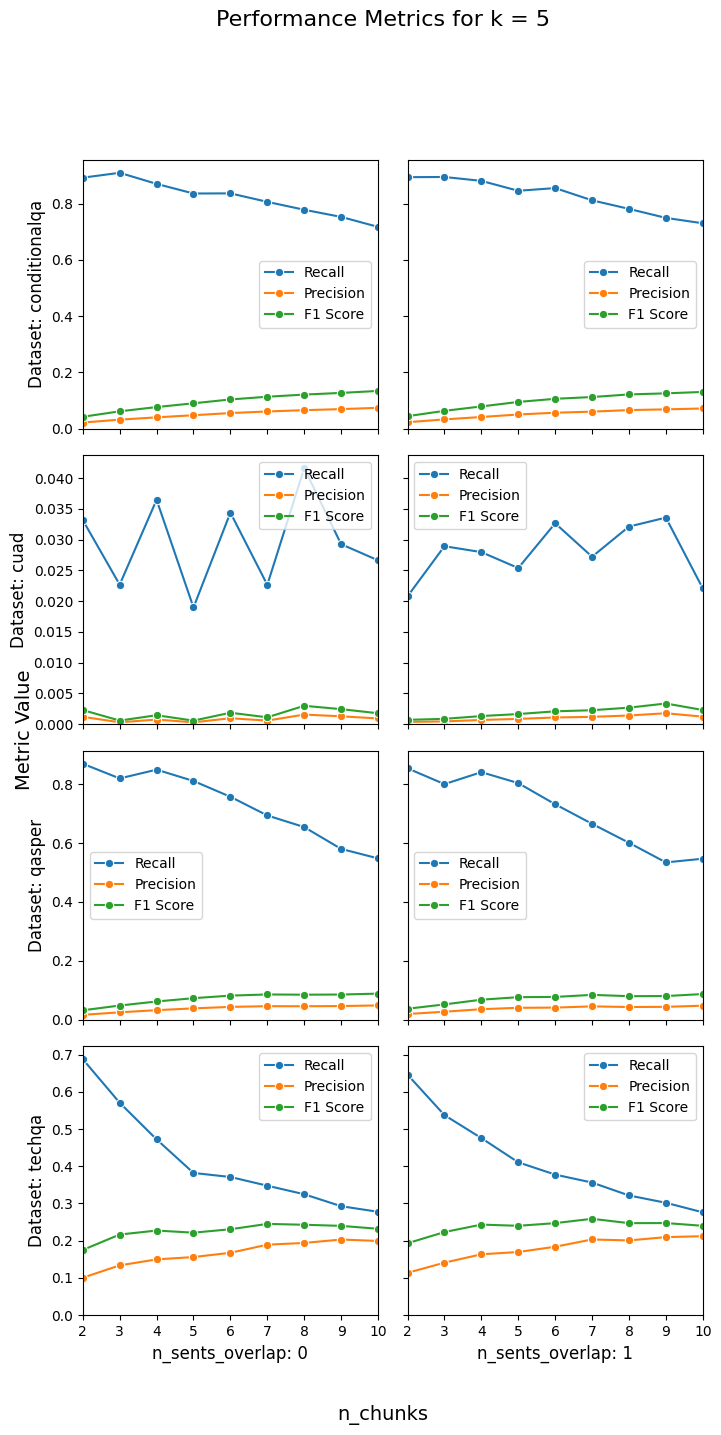

Showing plot for k=10


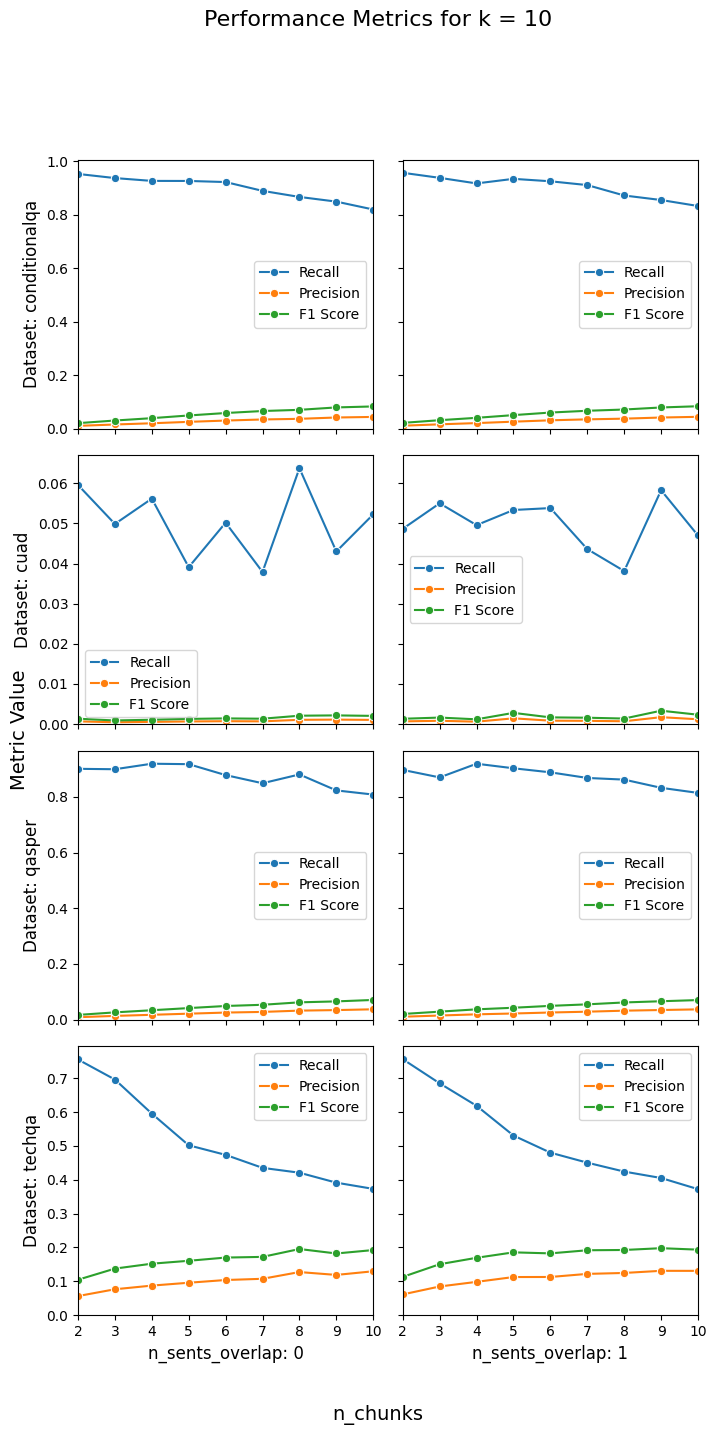

In [26]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'PositionalChunker'
subset_df = get_chunker_df(df, chunker_name)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['n_chunks'] = subset_df['n_chunks'].astype(int)
subset_df['n_sents_overlap'] = subset_df['n_sents_overlap'].astype(int)

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
n_chunks_values = sorted(subset_df['n_chunks'].unique())
n_sents_overlap_values = sorted(subset_df['n_sents_overlap'].unique())

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(n_sents_overlap_values),
                             figsize=(4*len(n_sents_overlap_values), 15), sharex=True, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, n_sents_overlap in enumerate(n_sents_overlap_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['n_sents_overlap'] == n_sents_overlap]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='n_chunks', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='n_chunks', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='n_chunks', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xlim(n_chunks_values[0], n_chunks_values[-1])
            ax.set_xticks(n_chunks_values, n_chunks_values)

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, n_sents_overlap in enumerate(n_sents_overlap_values):
        axes[-1, j].set_xlabel(f'n_sents_overlap: {n_sents_overlap}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    fig.text(0.5, 0.04, 'n_chunks', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()

## LangchainChunker

Showing plot for k=1


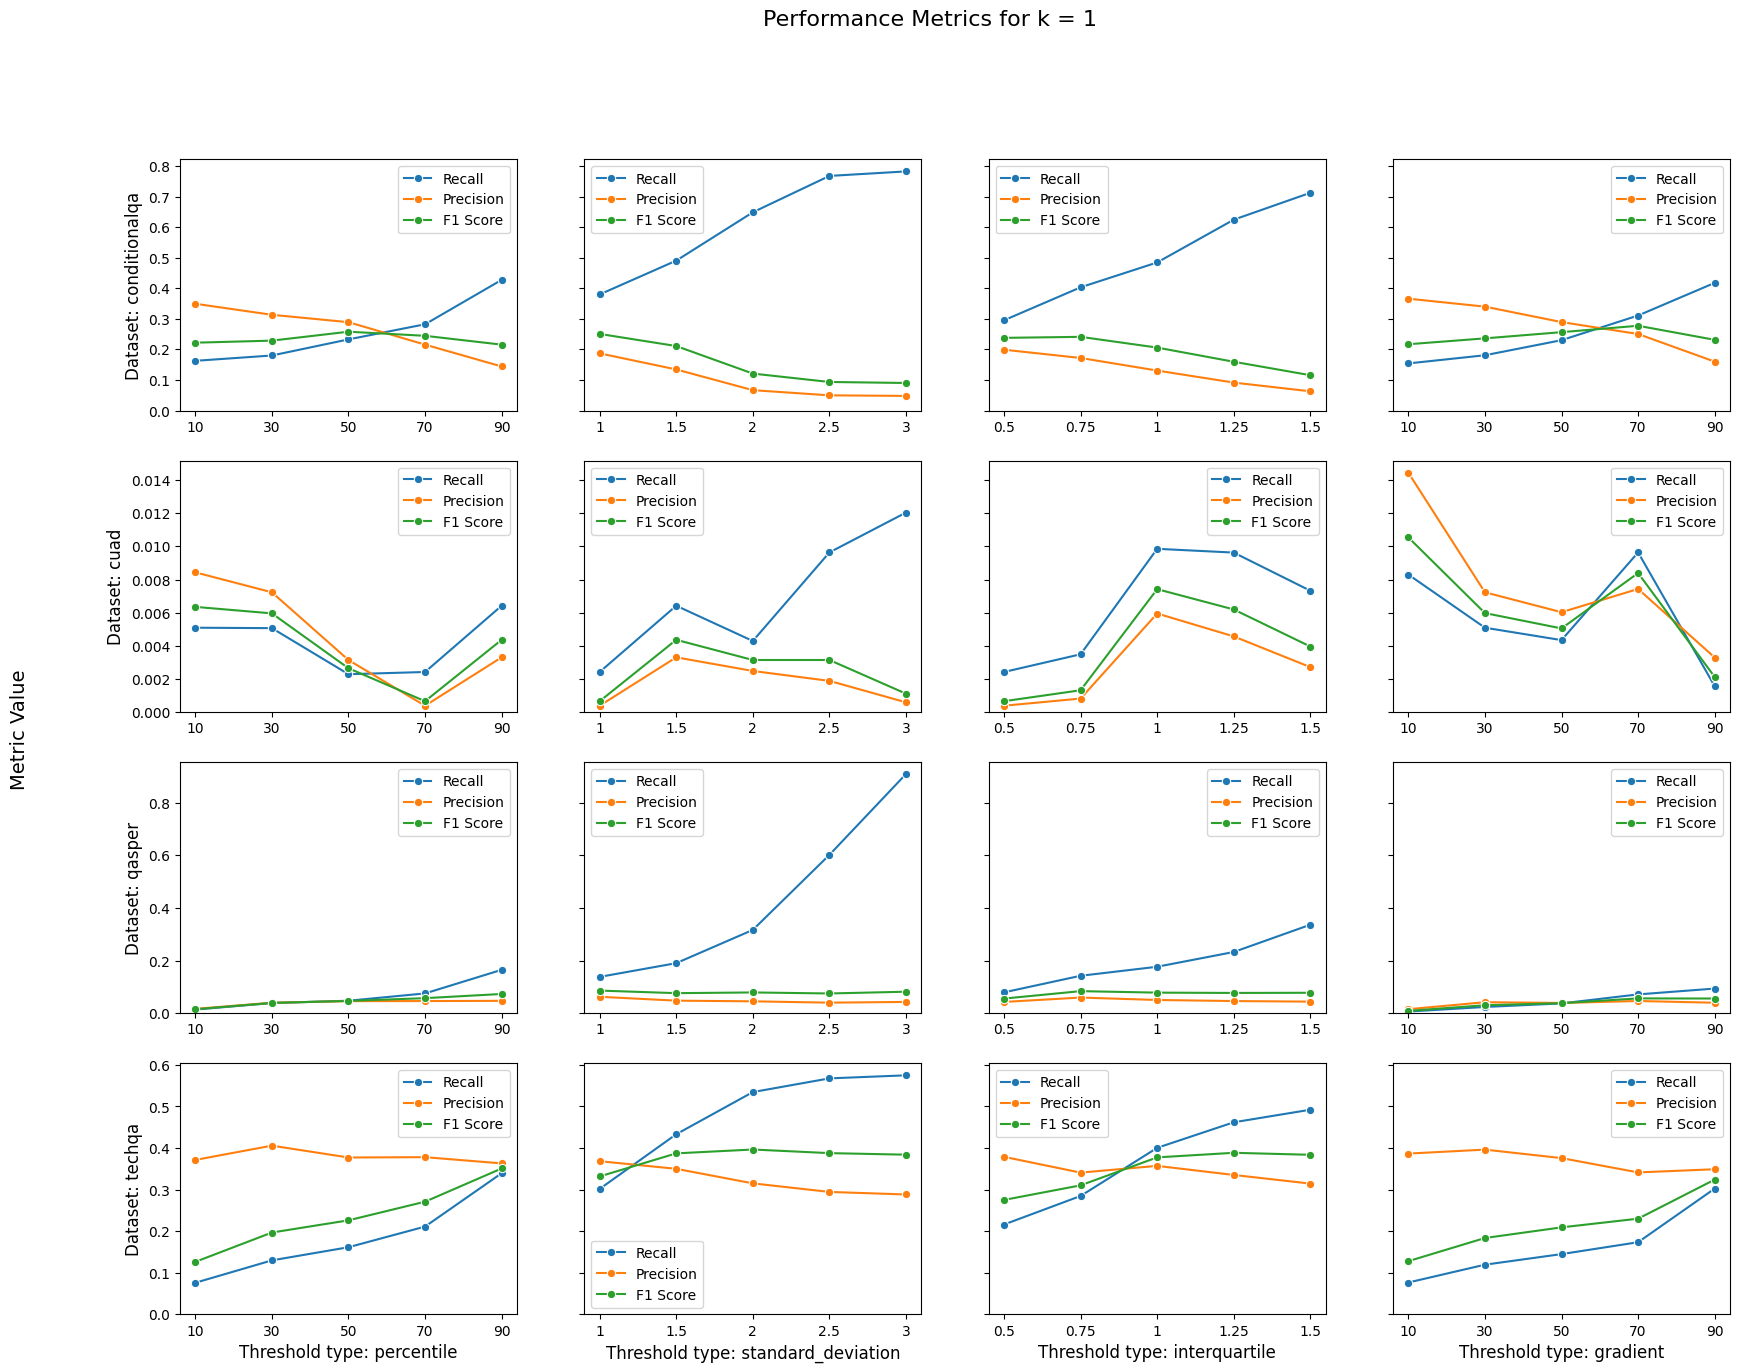

Showing plot for k=3


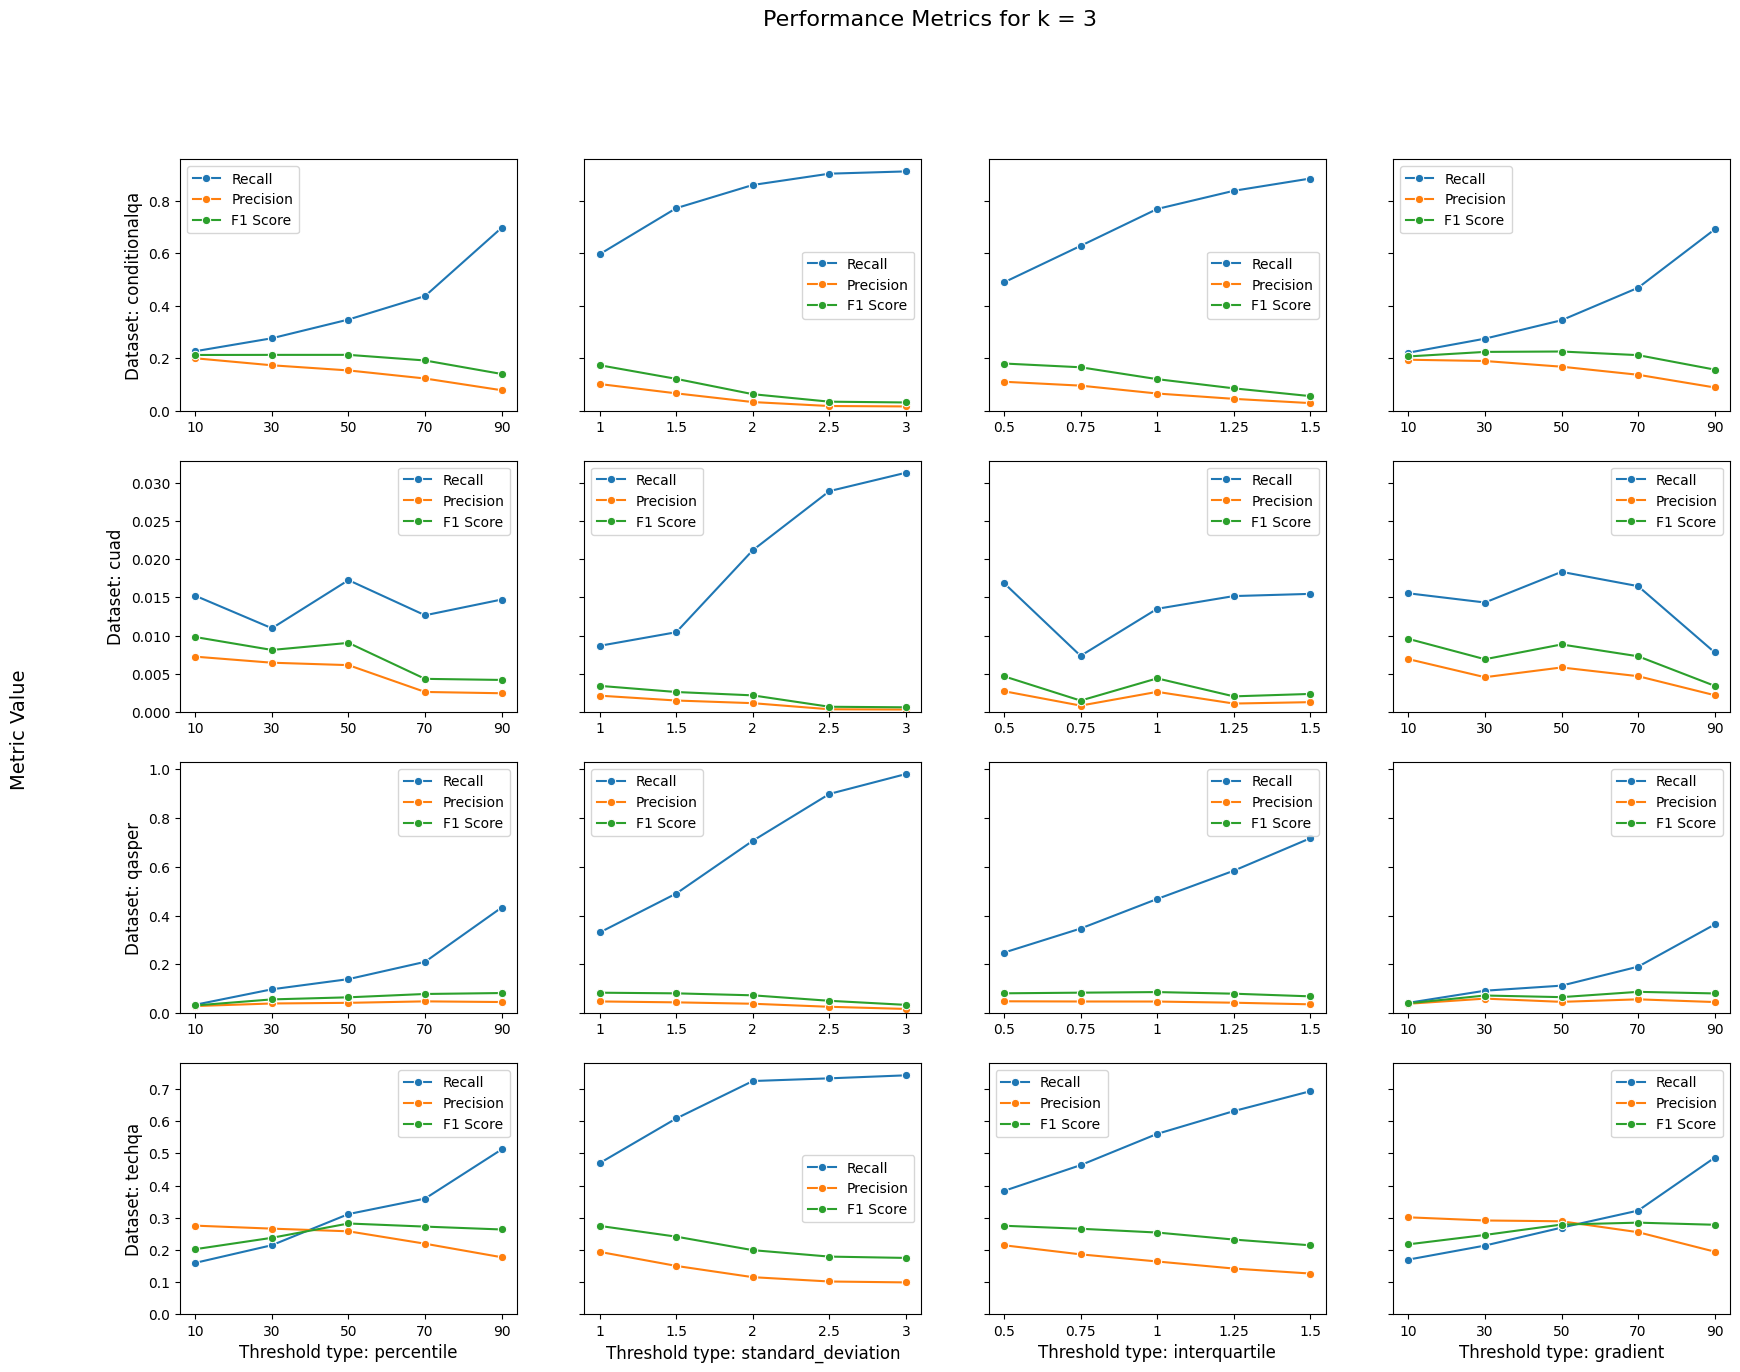

Showing plot for k=5


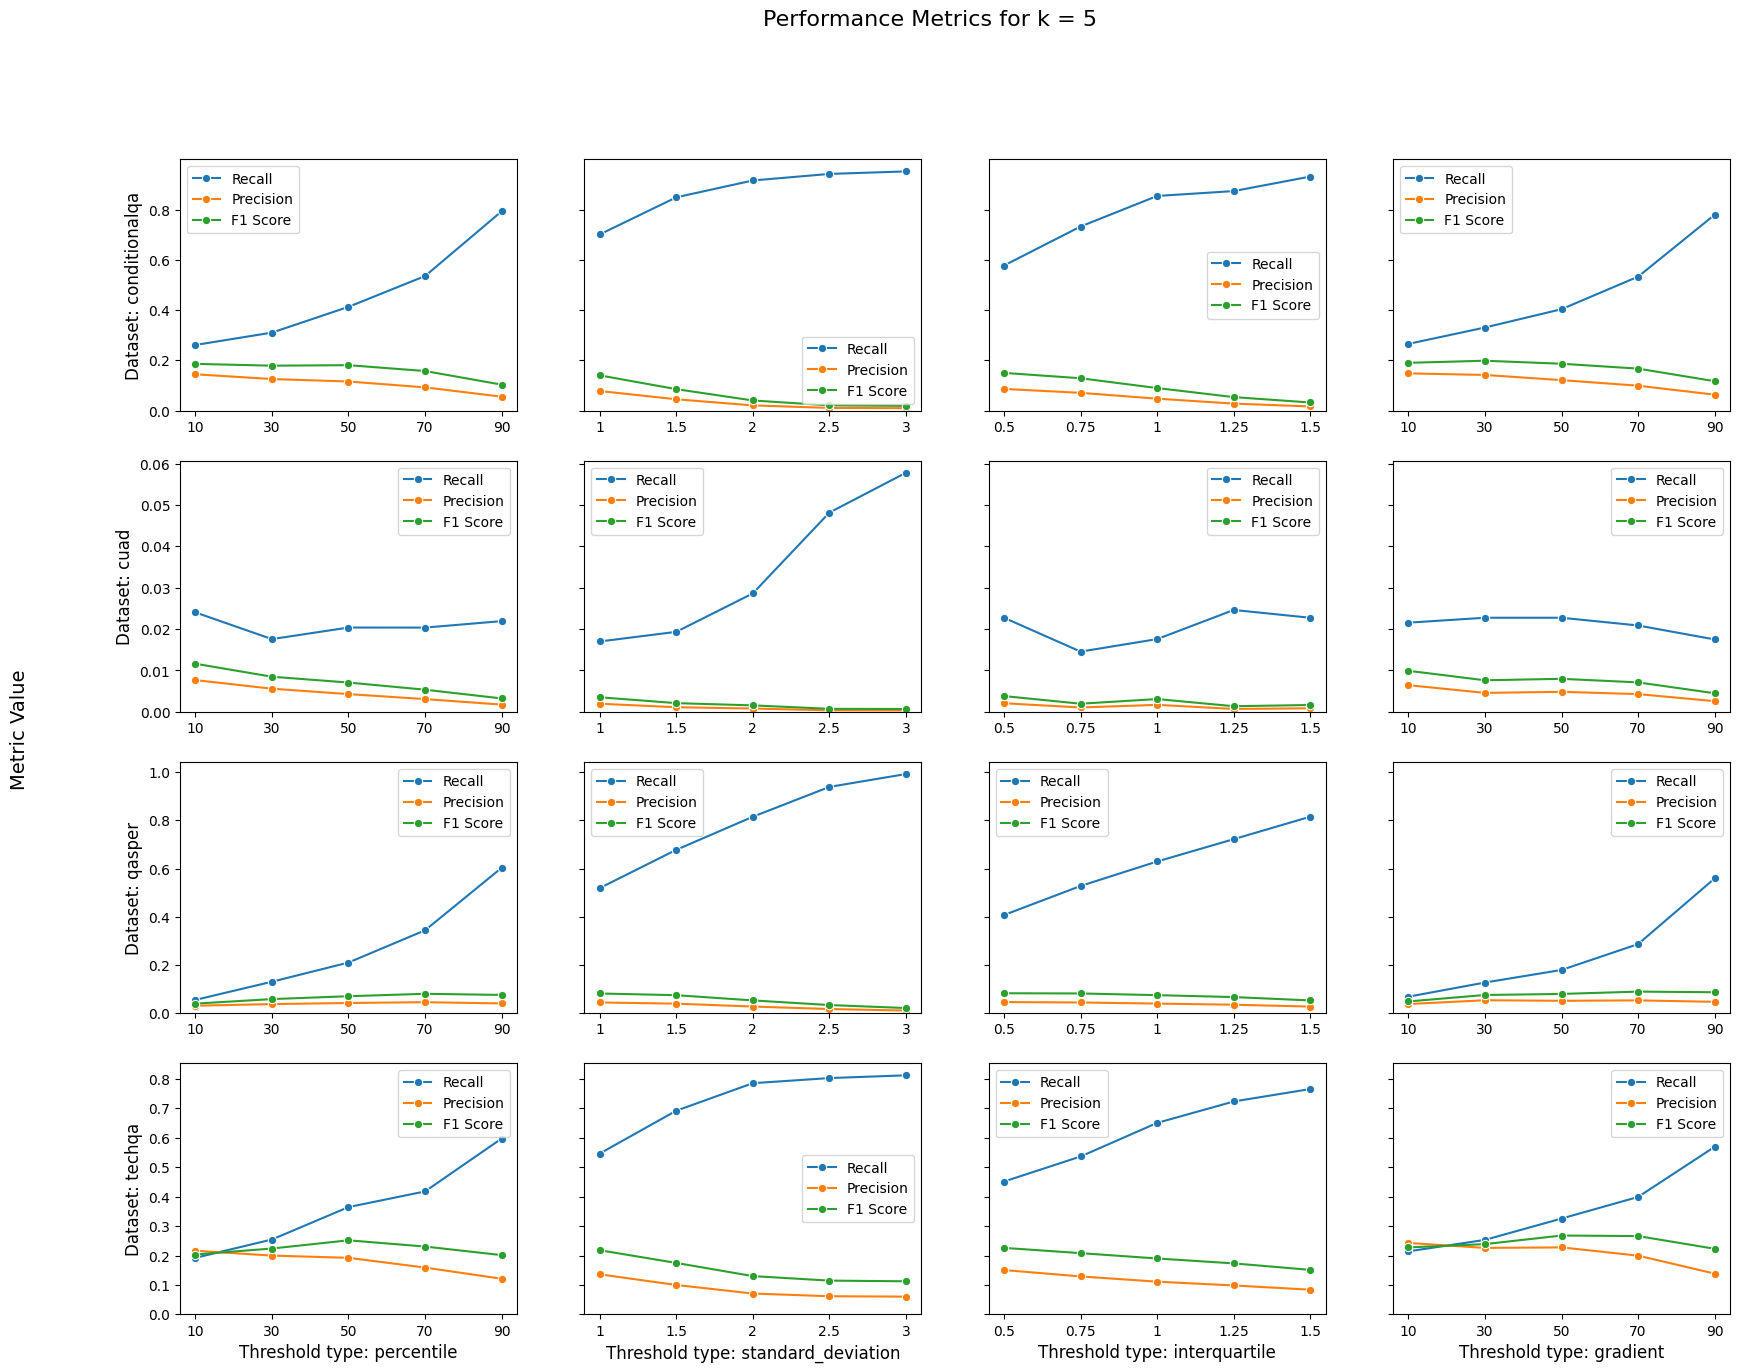

Showing plot for k=10


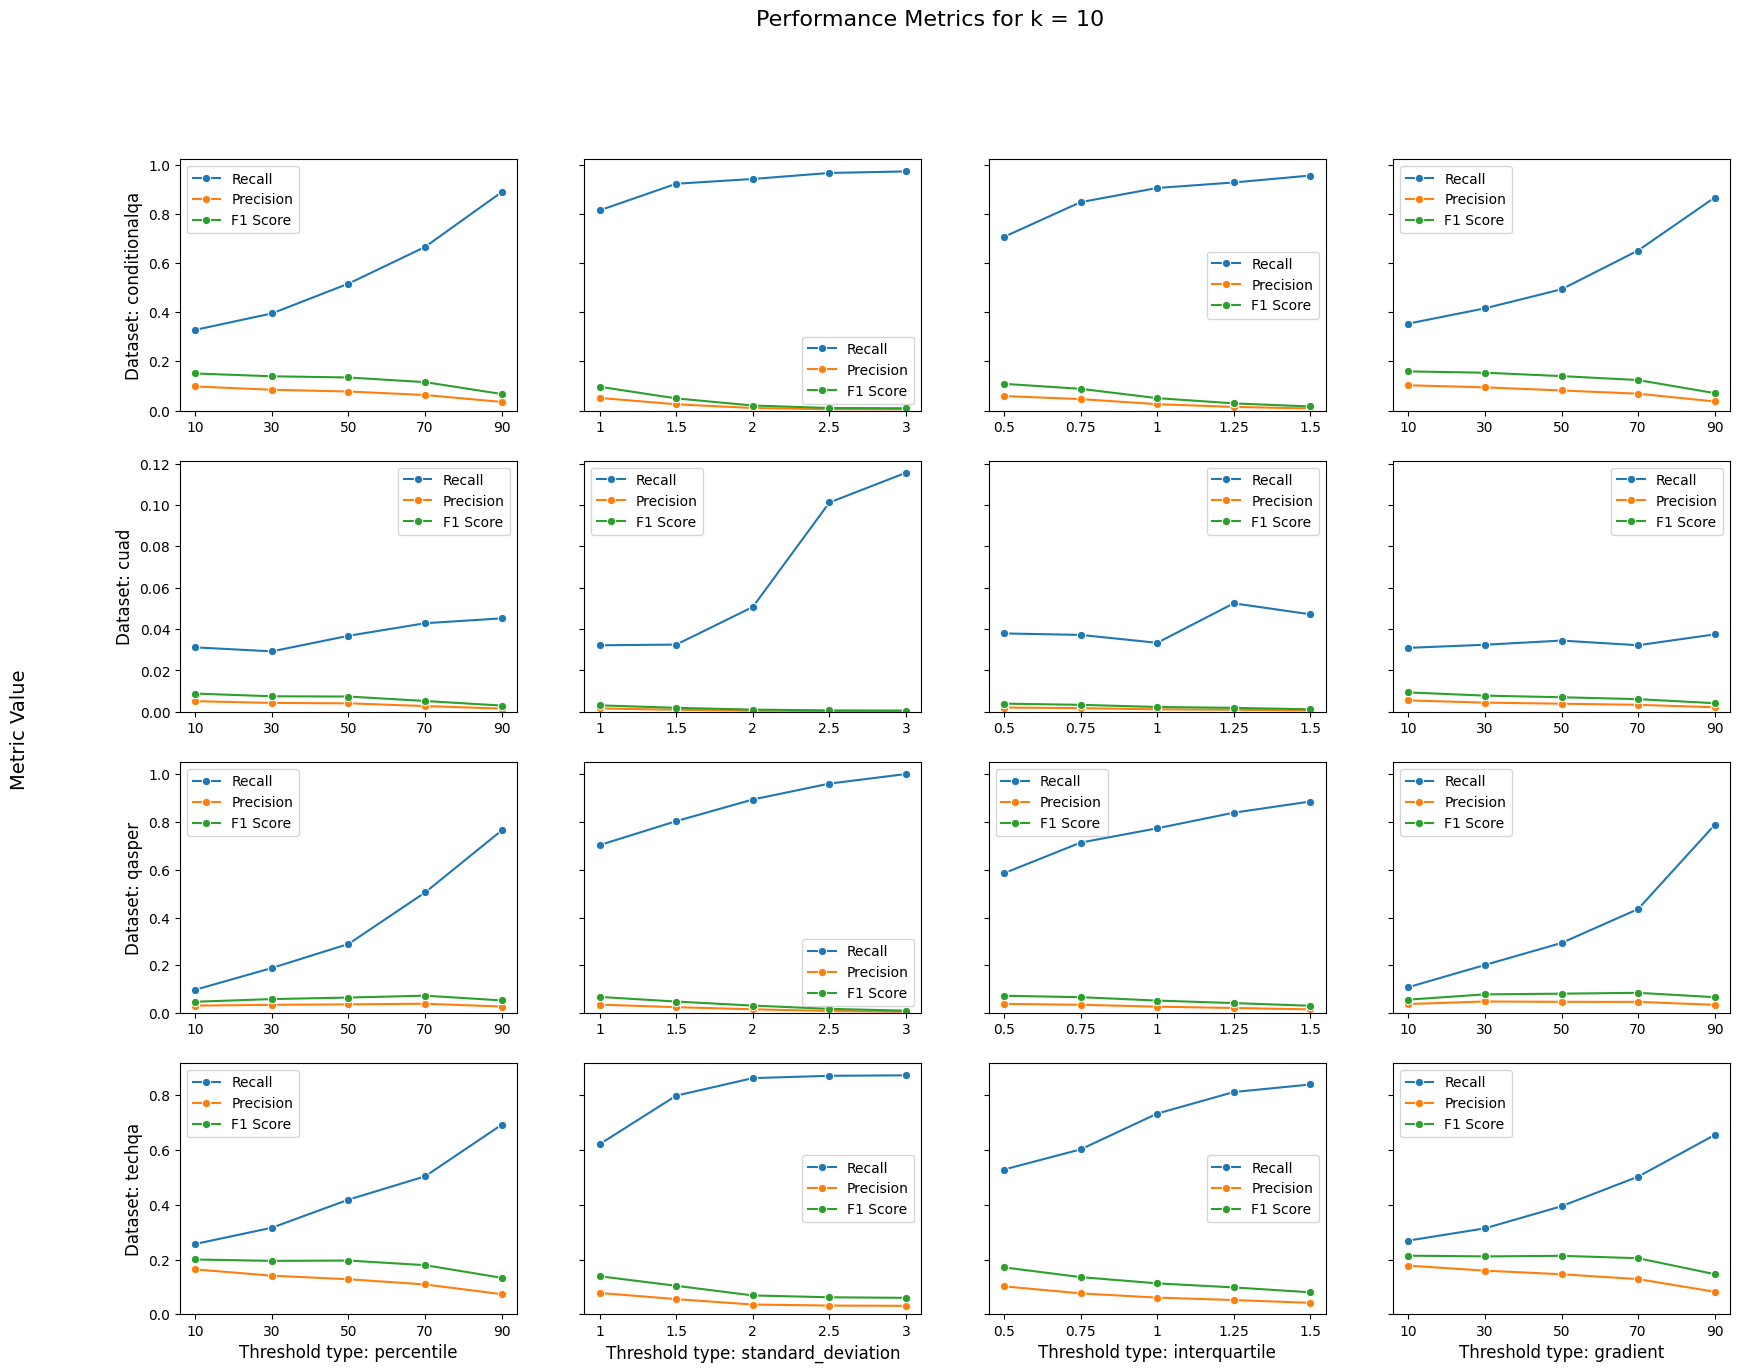

In [33]:
# Step 1: Subset the DataFrame for 'SingleLinkageChunker'
chunker_name = 'LangchainChunker'
subset_df = get_chunker_df(df, chunker_name)
subset_df.drop(columns=['breakpoint_threshold_type_standard'], inplace=True)
subset_df.fillna('standard_deviation', inplace=True)

# Ensure that 'lamda' and 'n_clusters' are numeric
subset_df['breakpoint_threshold_amount'] = subset_df['breakpoint_threshold_amount'].astype(float)

# Step 2: Define the unique values for 'k', 'dataset', and 'lamda'
k_values = sorted(subset_df['k'].unique())
datasets = sorted(subset_df['dataset'].unique())
breakpoint_threshold_type_values = subset_df['breakpoint_threshold_type'].unique()
breakpoint_threshold_amount_values = sorted(subset_df['breakpoint_threshold_amount'].unique())

threshold_amounts_mapping = {
    'percentile': [10, 30, 50, 70, 90],
    'standard_deviation': [1, 1.5, 2, 2.5, 3],
    'interquartile': [0.5, 0.75, 1, 1.25, 1.5],
    'gradient': [10, 30, 50, 70, 90]
}

# Step 3: Create plots for each 'k' value
for k in k_values:
    # Filter the DataFrame for the current 'k' value
    k_df = subset_df[subset_df['k'] == k]

    # Create a figure with appropriate size
    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(breakpoint_threshold_type_values),
                             figsize=(20, 15), sharex=False, sharey='row')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Step 4: Iterate over datasets and lamda values to fill the subplots
    for i, dataset in enumerate(datasets):
        # Get the maximum y-axis value for this dataset (row)
        dataset_df = k_df[k_df['dataset'] == dataset]
        y_max = dataset_df[['recall', 'precision', 'f1']].max().max()

        for j, breakpoint_threshold_type in enumerate(breakpoint_threshold_type_values):
            ax = axes[i, j]

            # Filter data for the current dataset and lamda
            plot_df = dataset_df[dataset_df['breakpoint_threshold_type'] == breakpoint_threshold_type]

            # If no data is available, hide the subplot
            if plot_df.empty:
                ax.set_visible(False)
                continue

            threshold_amounts = threshold_amounts_mapping[breakpoint_threshold_type]

            # Ensure the x-axis values are sorted according to the specified amounts
            plot_df = plot_df[plot_df['breakpoint_threshold_amount'].isin(threshold_amounts)]
            plot_df = plot_df.sort_values('breakpoint_threshold_amount')

            # Plot recall, precision, and f1 against n_clusters
            sns.lineplot(data=plot_df, x='breakpoint_threshold_amount', y='recall', ax=ax, label='Recall', marker='o')
            sns.lineplot(data=plot_df, x='breakpoint_threshold_amount', y='precision', ax=ax, label='Precision', marker='o')
            sns.lineplot(data=plot_df, x='breakpoint_threshold_amount', y='f1', ax=ax, label='F1 Score', marker='o')

            # Set x-axis range from 2 to 10
            ax.set_xticks(threshold_amounts, threshold_amounts)

            # Set y-axis range from 0 to y_max
            ax.set_ylim(0, y_max * 1.05)  # Slightly increase y_max for better visualization

            # Remove individual subplot titles
            ax.set_title('')

            ax.legend()
            # Only show legend in the first subplot
            # if i == 0 and j == 0:
            #     ax.legend()
            # else:
            #     ax.legend().remove()

            # Hide x and y labels for inner plots
            if i < len(datasets) - 1:
                ax.set_xlabel('')
            if j > 0:
                ax.set_ylabel('')

        # Set the row title on the left
        # axes[i, 0].annotate(f'Dataset: {dataset}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        #                     xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
        #                     size='large', ha='right', va='center', rotation=90)
        axes[i, 0].set_ylabel(f'Dataset: {dataset}', fontsize=12)

    # Set the column titles at the bottom
    for j, breakpoint_threshold_type in enumerate(breakpoint_threshold_type_values):
        axes[-1, j].set_xlabel(f'Threshold type: {breakpoint_threshold_type}', fontsize=12)
        # axes[-1, j].xaxis.set_label_coords(0.5, -0.2)

    # Add a common x-axis label
    # fig.text(0.5, 0.04, 'n_chunks', ha='center', fontsize=14)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Metric Value', va='center', rotation='vertical', fontsize=14)

    # Add an overall title for the figure
    plt.suptitle(f'Performance Metrics for k = {k}', fontsize=16)

    # Show the plot
    print(f"Showing plot for k={k}")
    plt.show()